In [3]:
from benchmark_helpers import get_problems, get_args_and_problems, print_, PATH_FORM_HYPERPARAMS


import os
import pickle
import traceback
import argparse
import random
import math
import copy
import time
from kmodes.kprototypes import KPrototypes

import sys
sys.path.append('..')

from lib.algorithms import PathFormulation
from lib.problem import Problem
from lib.algorithms.abstract_formulation import Objective
from lib.graph_utils import compute_in_or_out_flow, path_to_edge_list, assert_flow_conservation, check_feasibility
from collections import defaultdict
import ncflow

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from partition_entities import split_generic, check_dims

TOP_DIR = 'path-form-logs'
HEADERS = [
    'problem', 'num_nodes', 'num_edges', 'traffic_seed', 'scale_factor',
    'tm_model', 'num_commodities', 'total_demand', 'algo', 'num_paths',
    'edge_disjoint', 'dist_metric', 'total_flow', 'runtime'
]
PLACEHOLDER = ','.join('{}' for _ in HEADERS)


In [4]:
# This function returns a dict mapping each commodity to a one-hot-encoded edge vector,
# as well as it's normalized demand
def create_edges_onehot_dict(problem, pf_original):
    paths_dict = pf_original.get_paths(problem)
    com_list = problem.commodity_list
    num_entities = len(com_list)
    num_edges = len(problem.G.edges)
    enum_edges_dict = {}
    for i, edge in enumerate(problem.G.edges):
        enum_edges_dict[edge] = i

    # create dictionary of all edges used by each commodity
    com_path_edges_dict = defaultdict(list)
    min_demand = np.inf
    max_demand = 0
    for k, (source, target, demand) in com_list:
        paths_array = paths_dict[(source, target)]
        if min_demand > demand:
            min_demand = demand
        if max_demand < demand:
            max_demand = demand
            
        for path in paths_array:
            com_path_edges_dict[(k, source, target, demand)] += list(path_to_edge_list(path))

    com_path_edges_onehot_dict = defaultdict(list)
    np_data = np.zeros((num_entities,num_edges+1))
    for (k, source, target, demand), edge_list in com_path_edges_dict.items():
        onehot_edge = [0]*num_edges
        for edge in edge_list:
            edge_i = enum_edges_dict[edge]
            onehot_edge[edge_i] = 1
            np_data[k,edge_i] = 1
        # add in normalized demand as a dimension
        norm_demand = (demand - min_demand)/(max_demand-min_demand)
        com_path_edges_onehot_dict[(k, source, target, demand)] = onehot_edge + [norm_demand]
        np_data[k,-1] = norm_demand

    return com_path_edges_onehot_dict

# a wrapper function for calling split_generic.
# the return value is a list of subproblems
def split_generic_wrapper(problem, pf, num_subproblems, verbose=False, method='means'):
    
    input_dict = create_edges_onehot_dict(problem, pf)
    
    # create subproblems, zero out commodities in traffic matrix that aren't assigned to each 
    sub_problems = [problem.copy() for _ in range(num_subproblems)]
    if num_subproblems == 1:
        return sub_problems
    
    entity_assignments_lists = split_generic(input_dict, num_subproblems, verbose=verbose, method=method)
    
    for i in range(num_subproblems):

        #zero out all commodities not assigned to subproblem i
        for ind, source, target, demand in entity_assignments_lists[i]:
            for j in range(num_subproblems):
                if i == j:
                    continue
                sub_problems[j].traffic_matrix.tm[source,target] = 0

        # split the capacity of each link
        for u,v in sub_problems[i].G.edges:
            sub_problems[i].G[u][v]['capacity'] = sub_problems[i].G[u][v]['capacity']/num_subproblems

    return sub_problems
    

In [5]:
original_dist = [2,5]
A = [[1,2,3], [4,5,6]]
B = [2,5]
C = [3,6]
#print(calc_dist(A,B,original_dist))
#print(calc_dist(A,C,original_dist))

input_dict = {'A': [1,4,3],
              'B': [4,3,6],
              'C': [7,8,2],
              'D': [1,2,3],
              'E': [4,5,6],
              'F': [9,8,1],
              'G': [1,2,4],
              'H': [4,2,3],
              'I': [7,8,5]}
subproblem_list = split_generic(input_dict,2, verbose=True, method='means')
check_dims(subproblem_list, input_dict)


topo_fname = "../topologies/topology-zoo/Ion.graphml"#GtsCe.graphml"
#tm_fname = "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl"
tm_fname = "../traffic-matrices/uniform/Ion.graphml_uniform_1545787193_64.0_0.15_traffic-matrix.pkl"
num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
    
pf_original = PathFormulation.new_max_flow(
    num_paths,
    edge_disjoint=edge_disjoint,
    dist_metric=dist_metric)
with open('path-form.csv', 'a') as results:
    print_(','.join(HEADERS), file=results)
    
    problem = Problem.from_file(topo_fname, tm_fname)

    paths_dict = pf_original.get_paths(problem)
    com_list = problem.commodity_list
    num_entities = len(com_list)
    num_edges = len(problem.G.edges)
    enum_edges_dict = {}
    for i, edge in enumerate(problem.G.edges):
        enum_edges_dict[edge] = i

    # create dictionary of all edges used by each commodity
    com_path_edges_dict = defaultdict(list)
    min_demand = np.inf
    max_demand = 0
    for k, (source, target, demand) in com_list:
        paths_array = paths_dict[(source, target)]
        if min_demand > demand:
            min_demand = demand
        if max_demand < demand:
            max_demand = demand
            
        for path in paths_array:
            com_path_edges_dict[(k, source, target, demand)] += list(path_to_edge_list(path))

    com_path_edges_onehot_dict = defaultdict(list)
    np_data = np.zeros((num_entities,num_edges+1))
    for (k, source, target, demand), edge_list in com_path_edges_dict.items():
        onehot_edge = [0]*num_edges
        for edge in edge_list:
            edge_i = enum_edges_dict[edge]
            onehot_edge[edge_i] = 1
            np_data[k,edge_i] = 1
        # add in normalized demand as a dimension
        norm_demand = (demand - min_demand)/(max_demand-min_demand)
        com_path_edges_onehot_dict[k] = onehot_edge + [norm_demand]
        np_data[k,-1] = norm_demand
    
    #print("creating subproblem list...")
    #subproblem_list_meansplit = split_generic(com_path_edges_onehot_dict, 2, verbose=False)
    

Assigned 0 entities
[[[1], [4], [3]], [[], [], []]]
[['A'], []]


[[[1], [4], [3]], [[4], [3], [6]]]
[['A'], ['B']]


[[[1], [4], [3]], [[4, 7], [3, 8], [6, 2]]]
[['A'], ['B', 'C']]


[[[1], [4], [3]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A'], ['B', 'C', 'D']]


[[[1, 4], [4, 5], [3, 6]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A', 'E'], ['B', 'C', 'D']]


[[[1, 4, 9], [4, 5, 8], [3, 6, 1]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A', 'E', 'F'], ['B', 'C', 'D']]


[[[1, 4, 9, 1], [4, 5, 8, 2], [3, 6, 1, 4]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A', 'E', 'F', 'G'], ['B', 'C', 'D']]


[[[1, 4, 9, 1, 4], [4, 5, 8, 2, 2], [3, 6, 1, 4, 3]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A', 'E', 'F', 'G', 'H'], ['B', 'C', 'D']]


[[[1, 4, 9, 1, 4, 7], [4, 5, 8, 2, 2, 8], [3, 6, 1, 4, 3, 5]], [[4, 7, 1], [3, 8, 2], [6, 2, 3]]]
[['A', 'E', 'F', 'G', 'H', 'I'], ['B', 'C', 'D']]


checking split of 3 dimensions over 2 subproblems
subproblem 0: [4.33333333 4.83333333 3.66666667]
subproblem 1: [4.         4

In [ ]:
kp = KPrototypes(n_clusters=20, init='Huang', n_init=1, verbose=1, n_jobs=24, max_iter=8)
start_time = time.time()
clusters = kp.fit_predict(np_data, categorical=[ x for x in range(0,num_edges)])
print("--- %s seconds ---" % (time.time() - start_time))

In [6]:
# paths_dict: key: (source, target), value: array of paths,
#             where a path is a list of sequential nodes
#             use lib.graph_utils.path_to_edge_list to get edges.
def split_problem_smartpath(problem, num_subproblems, paths_dict):
    com_list = problem.commodity_list

    # create dictionary of all edges used by each commodity
    com_path_edges_dict = defaultdict(list)
    for k, (source, target, demand) in com_list:
        paths_array = paths_dict[(source, target)]
        for path in paths_array:
            com_path_edges_dict[(k, source, target)] += list(path_to_edge_list(path))

    # for each edge, split all commodities using that edge across subproblems
    subproblem_com_indices = defaultdict(list)
    current_subproblem = 0
    for (u,v) in problem.G.edges:
        coms_on_edge = [x for x in com_path_edges_dict.keys() if (u,v) in com_path_edges_dict[x]]

        # split commodities that share path across all subproblems
        for (k, source, target) in coms_on_edge:
            subproblem_com_indices[current_subproblem] += [(k,source,target)]
            current_subproblem = (current_subproblem + 1) % num_subproblems
            # remove commodity from cosideration when processing later edges
            del com_path_edges_dict[(k, source, target)]

    # create subproblems, zero out commodities in traffic matrix that aren't assigned to each 
    sub_problems = []
    for i in range(num_subproblems):

        sub_problems.append(problem.copy())

        #zero out all commodities not assigned to subproblem i
        for k in subproblem_com_indices.keys():
            if k == i:
                continue
            zero_out_list = subproblem_com_indices[k]
            for ind, source, target in zero_out_list:
                sub_problems[-1].traffic_matrix.tm[source,target] = 0

        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems

#Input: a Problem, and a list of number representing the divisions
def split_problem(problem, num_subproblems):
    sub_problems = []
    num_rows = len(problem.traffic_matrix.tm)
    rows_per_problem = math.floor(num_rows/num_subproblems)
    shuffled_indices = list(range(num_rows))

    for i in range(num_subproblems):

        sub_problems.append(problem.copy())
        for indx, j in enumerate(shuffled_indices):

            # zero out all rows except those in the corresponding block of shuffled indices
            # first, cover special case for last block
            if i == num_subproblems-1:
                if indx < i*rows_per_problem:
                    sub_problems[-1].traffic_matrix.tm[j,:] = 0

            elif (indx < i*rows_per_problem) or (indx >= (i+1)*rows_per_problem):
                sub_problems[-1].traffic_matrix.tm[j,:] = 0

        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems

def split_random2(problem, num_subproblems):
    sub_problems = [problem.copy() for _ in range(num_subproblems)]
    num_coms = len(problem.commodity_list)
    max_demand = 100/num_subproblems
    
    # find out how many times you have to halve demand so its within max 
    b = 0
    while demand/(2**b) > max_demand:
        b += 1         
    num_entity_splits = min(2**b, num_subproblems)
    # create list of sps to assign demand to
    assigned_sps_list = np.random.permutation(np.arange(num_subproblems))[:num_entity_splits]

    # zero our each subproblem's tm entry for this entity, except for assigned sp's who each get a portion
    for sp in range(num_subproblems):
        if sp in assigned_sps_list:
            sub_problems[sp].traffic_matrix.tm[source, target] /= num_entity_splits
        else:
            sub_problems[sp].traffic_matrix.tm[source, target] = 0
            
    for sub_problem in sub_problems:
        for u,v in sub_problems[-1].G.edges:
            sub_problem.G[u][v]['capacity'] = sub_problem.G[u][v]['capacity']/num_subproblems
    return sub_problems

# assign commodities to subproblems at random
def split_random(problem, num_subproblems):
    sub_problems = [problem.copy() for _ in range(num_subproblems)]
    num_coms = len(problem.commodity_list)
    
    for k, (source, target, demand) in problem.commodity_list:
        sp_assignment = random.randint(0,num_subproblems-1)
        for sp in range(num_subproblems):
            if sp == sp_assignment:
                continue
            sub_problems[sp].traffic_matrix.tm[source,target] = 0
    for sub_problem in sub_problems:
        for u,v in sub_problems[-1].G.edges:
            sub_problem.G[u][v]['capacity'] = sub_problem.G[u][v]['capacity']/num_subproblems
    return sub_problems

In [7]:
# Sweep topos and traffic matrices for that topo. For each combo, record the
# runtime and total flow for each algorithm
# split can be random, means, covs, clusters, tailored, or skewed
def benchmark_split(problems, num_subproblems_list, obj, split='random'):
    num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS

    if (obj == 'max_flow'):
        pf_original = PathFormulation.new_max_flow(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    elif (obj == 'min_max_link_util'):
        pf_original = PathFormulation.new_min_max_link_util(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    else:
        print(obj + " not supported")
        return

    all_results = {}
    all_runtimes = {}
    all_sol_dicts = {}
    with open('path-form.csv', 'a') as results:
        print_(','.join(HEADERS), file=results)
        for problem_name, topo_fname, tm_fname in problems:
            problem = Problem.from_file(topo_fname, tm_fname)

            paths_dict = pf_original.get_paths(problem)

            problem_results = [[] for _ in range(len(num_subproblems_list))]
            problem_runtimes = [[] for _ in range(len(num_subproblems_list))]
            problem_sol_dicts = [[] for _ in range(len(num_subproblems_list))]
            for nsp_i, num_subproblems in enumerate(num_subproblems_list):
                
                if split == 'tailored':
                    problem_list = split_problem_smartpath(problem, num_subproblems, paths_dict)
                elif split == 'skewed':
                    problem_list = split_problem(problem, num_subproblems)
                elif split == 'random':
                    problem_list = split_random(problem, num_subproblems)
                elif split == 'random2':
                    problem_list = split_random2(problem, num_subproblems)
                elif split == 'means' or split == 'covs':
                    problem_list = split_generic_wrapper(problem, pf_original, 
                                                         num_subproblems, method=split)
              
                sum_obj_val = 0
                for sp_i, sub_problem in enumerate(problem_list):

                    print_(sub_problem.name, tm_fname)
                    traffic_seed = sub_problem.traffic_matrix.seed
                    total_demand = sub_problem.total_demand
                    print_('traffic seed: {}'.format(traffic_seed))
                    print_('traffic scale factor: {}'.format(
                        sub_problem.traffic_matrix.scale_factor))
                    print_('traffic matrix model: {}'.format(
                        sub_problem.traffic_matrix.model))
                    print_('total demand: {}'.format(total_demand))

                    run_dir = os.path.join(
                        TOP_DIR, sub_problem.name,
                        '{}-{}'.format(traffic_seed, sub_problem.traffic_matrix.model))
                    if not os.path.exists(run_dir):
                        os.makedirs(run_dir)

                    try:
                        print_(
                            '\\nPath formulation, {} paths, edge disjoint {}, dist metric {}'
                            .format(num_paths, edge_disjoint, dist_metric))
                        with open(
                                os.path.join(
                                    run_dir,
                                    '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}.txt'
                                    .format(sub_problem.name, num_paths, edge_disjoint,
                                            dist_metric)), 'w') as log:

                            if (obj == 'max_flow'):
                                pf = PathFormulation.new_max_flow(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            elif (obj == 'min_max_link_util'):
                                pf = PathFormulation.new_min_max_link_util(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            else:
                                print(obj + " not supported")
                                break

                            pf.solve(sub_problem)
                            pf_sol_dict = pf.extract_sol_as_dict()
                            with open(
                                    os.path.join(
                                        run_dir,
                                        '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}_sol-dict.pkl'
                                        .format(sub_problem.name, num_paths, edge_disjoint,
                                                dist_metric)), 'wb') as w:
                                pickle.dump(pf_sol_dict, w)

                        result_line = PLACEHOLDER.format(
                            sub_problem.name,
                            len(sub_problem.G.nodes),
                            len(sub_problem.G.edges),
                            traffic_seed,
                            sub_problem.traffic_matrix.scale_factor,
                            sub_problem.traffic_matrix.model,
                            len(problem.commodity_list),
                            total_demand,
                            'path_formulation',
                            num_paths,
                            edge_disjoint,
                            dist_metric,
                            pf.obj_val,
                            pf.runtime,
                        )
                        print_(result_line, file=results)
                        problem_results[nsp_i].append(pf.obj_val)
                        problem_runtimes[nsp_i].append(pf.runtime)
                        problem_sol_dicts[nsp_i].append(pf_sol_dict)
                        sum_obj_val += pf.obj_val
                    except Exception:
                        print_(
                            'Path formulation {} paths, edge disjoint {}, dist metric {}, Problem {}, traffic seed {}, traffic model {} failed'
                            .format(num_paths, edge_disjoint, dist_metric,
                                    sub_problem.name, traffic_seed,
                                    sub_problem.traffic_matrix.model))
                        traceback.print_exc(file=sys.stdout)
                print("sum of obj vals: " + str(sum_obj_val))

            all_results[(problem_name, topo_fname, tm_fname)] = problem_results
            all_runtimes[(problem_name, topo_fname, tm_fname)] = problem_runtimes
            all_sol_dicts[(problem_name, topo_fname, tm_fname)] = problem_sol_dicts
    return all_results, all_runtimes, all_sol_dicts

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('--dry-run',
                        dest='dry_run',
                        action='store_true',
                        default=False)

parser.add_argument('--slices',
                        type=int,
                        choices=range(5),
                        nargs='+',
                        required=True)
args = parser.parse_args("--slices 0".split())

if not os.path.exists(TOP_DIR):
    os.makedirs(TOP_DIR)

#problems = get_problems(args)

if args.dry_run:
    print('Problems to run:')
    for problem in problems:
        print(problem)

p1 = ("uniform 64", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
p2 = ("poisson-inter 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl")
p3 = ("poisson-intra 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-intra/GtsCe.graphml_poisson_1367969278_128.0_200000000.0_0.1_2.25e-06_traffic-matrix.pkl")
p4 = ("uniform 8", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_19019979_8.0_0.05_traffic-matrix.pkl")

p5 = ("kdl_16", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl")
p6 = ("kdl_32", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1836337794_32.0_48001.9765625_True_traffic-matrix.pkl")
p7 = ("kdl_64", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_530572184_64.0_95909.890625_True_traffic-matrix.pkl")
p8 = ("kdl_128", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl")

p9 = ("cogentco_16", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl")
p10 = ("cogentco_32", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl")
p11 = ("cogentco_64", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1693196370_64.0_76793.84375_True_traffic-matrix.pkl")
p12 = ("cogentco_128", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl")

p13 = ("kdl_8", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl")

p14 = ("ER_32", "../topologies/erdos-renyi-1260231677.json",
       "../traffic-matrices/gravity/erdos-renyi-1260231677.json_gravity_479716829_32.0_15993702.0_True_traffic-matrix.pkl")

p15 = ("ion_64", "../topologies/topology-zoo/Ion.graphml",
       "../traffic-matrices/uniform/Ion.graphml_uniform_1545787193_64.0_0.15_traffic-matrix.pkl")

p16 = ("kdl_64_pinter", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1857279712_64.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl")
p17 = ("kdl_128_pinter", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1986708651_128.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl")
p18 = ("cogentco_64_pinter", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-inter/Cogentco.graphml_poisson_368595621_64.0_100.0_0.9_0.00105_traffic-matrix.pkl")
p19 = ("cogentco_128_pinter", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-inter/Cogentco.graphml_poisson_794082333_128.0_100.0_0.9_0.00105_traffic-matrix.pkl")

p20 = ("kdl_64_pintra", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_529831180_64.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl")
p21 = ("kdl_128_pintra", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_632211587_128.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl")
p22 = ("cogentco_64_pintra", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl")
p23 = ("cogentco_128_pintra", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1776689782_128.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl")

p24 = ("kdl_16_pinter", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1506113288_16.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl")
p25 = ("cogentco_16_pinter", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-inter/Cogentco.graphml_poisson_1185923933_16.0_100.0_0.9_0.00105_traffic-matrix.pkl")
p26 = ("kdl_16_pintra", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl")
p27 = ("cogentco_16_pintra", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl")
#num_subproblems = [64]
num_subproblems = [1,2,4,8,16,32]
#num_subproblems = [1,8]
#problems = [(os.path.basename(p1[1]), p1[1], p1[2])]
#problems = [p11,p12,p7,p8,p16,p17,p18,p19,p20,p21,p22,p23]#,p10,p11]
problems = [p22]#, p21, p22, p23]

obj_types = ["max_flow"]#, "min_max_link_util"]
#obj_types = ["min_max_link_util"]"

In [10]:
obj_type = 'max_flow'
split_methods = ['random', 'random2']#, 'skewed', 'tailored']#, 'covs', 'skewed', 'tailored']
results_all_mf = {}
runtimes_all_mf = {}
sol_dicts_all_mf = {}
for method in split_methods:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, split=method)
    results_all_mf[method] = results
    runtimes_all_mf[method] = runtimes
    sol_dicts_all_mf[method] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Cogentco.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 38612
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1730053.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20064 rows, 35854 columns and 362758 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-0

traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 397859.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5404 rows, 9030 columns and 91754 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 4379 rows and 5125 columns
Presolve time: 0.08s
Presolved: 1025 rows, 3905 columns, 26527 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.006e+04
 Factor NZ  : 4.732e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.790e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.14 s

Presolve time: 0.04s
Presolved: 1080 rows, 2779 columns, 22252 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.538e+04
 Factor NZ  : 5.482e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.136e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 295 iterations and 0.08 seconds
Optimal objective  1.906176773e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 231423.515625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2912 rows, 4441 column

traffic matrix model: poisson
total demand: 111938.125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1739 rows, 2270 columns and 22831 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 733 rows and 319 columns
Presolve time: 0.03s
Presolved: 1006 rows, 1951 columns, 16910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.708e+04
 Factor NZ  : 5.590e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.506e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by a

Presolve time: 0.04s
Presolved: 935 rows, 1774 columns, 15085 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.348e+04
 Factor NZ  : 4.705e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.846e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 766 iterations and 0.08 seconds
Optimal objective  5.844909972e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 133084.71875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1787 rows, 2386 columns an

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1680 rows, 2203 columns and 22183 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 758 rows and 402 columns
Presolve time: 0.03s
Presolved: 922 rows, 1801 columns, 15181 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.376e+04
 Factor NZ  : 5.116e+04 (roughly 2 MBytes of memory)
 Factor Ops : 5.900e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 955 iterations and 0.06 seconds
Optimal objective  6.215863127e+03
Cogentco.graphml ../traffic-matrices/poisso

  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 402 rows and 83 columns
Presolve time: 0.02s
Presolved: 684 rows, 1019 columns, 8671 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.671e+04
 Factor NZ  : 3.815e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.813e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 268 iterations and 0.03 seconds
Optimal objective  2.304238505e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 62540.82421875
\nPath formulation, 4 paths, edge disjoint True, dist metric

Optimal objective  2.067655927e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 52508.80078125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1099 rows, 1146 columns and 11756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 386 rows and 67 columns
Presolve time: 0.02s
Presolved: 713 rows, 1079 columns, 9599 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.


Presolve removed 430 rows and 137 columns
Presolve time: 0.01s
Presolved: 675 rows, 1014 columns, 8865 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.726e+04
 Factor NZ  : 4.146e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.556e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.04 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 290 iterations and 0.04 seconds
Optimal objective  2.439802302e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 48526.328125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optim

Optimal objective  2.321273549e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 48101.49609375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1040 rows, 1024 columns and 10319 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 420 rows and 77 columns
Presolve time: 0.02s
Presolved: 620 rows, 947 columns, 7494 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.4

Optimize a model with 1127 rows, 1186 columns and 11913 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 370 rows and 46 columns
Presolve time: 0.02s
Presolved: 757 rows, 1140 columns, 10020 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.973e+04
 Factor NZ  : 4.449e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.983e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 336 iterations and 0.04 seconds
Optimal objective  2.289012124e+03
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed:

Optimal objective  1.212500000e+05
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0625000e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.21 seconds
Optimal objective  6.062500000e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0


  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20064 rows and 35854 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0375000e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.21 seconds
Optimal objective  3.037500000e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 358

       0    3.0312500e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.21 seconds
Optimal objective  3.031250000e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
P

traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5156250e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.23 seconds
Optimal objective  1.515625000e+04
Cogentco.graphml ../traffic-matrices/poisson

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5156250e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.22 seconds
Optimal objective  1.515625000e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value o

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5156250e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.23 seconds
Optimal objective  1.515625000e+04
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_2075712807_64.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barr

traffic seed: 2075712807
traffic scale factor: 64.0
traffic matrix model: poisson
total demand: 1727109.0
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20063 rows, 35853 columns and 362756 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5156250e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.22 seconds
Optimal objective  1.515625000e+04
Cogentco.graphml ..

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 20063 rows and 35853 columns
Presolve time: 0.14s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5156250e+04   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 0 iterations and 0.21 seconds
Optimal objective  1.515625000e+04
sum of obj vals: 485031.25


In [16]:
problems_mmlu = [p5, p9, p24, p25, p26, p27]
obj_type = 'min_max_link_util'
split_methods = ['random']#, 'skewed', 'tailored']#, 'covs', 'skewed', 'tailored']
results_all_mmlu = {}
runtimes_all_mmlu = {}
sol_dicts_all_mmlu = {}
for method in split_methods:
    
    results, runtimes, sol_dicts = benchmark_split(problems_mmlu, num_subproblems, obj_type, split=method)
    results_all_mmlu[method] = results
    runtimes_all_mmlu[method] = runtimes
    sol_dicts_all_mmlu[method] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl
traffic seed: 1710674203
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 24000.064453125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 569535 rows, 1064238 columns and 30697154 nonzeros
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 106738 rows and 106161 columns (pr

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 143445 rows, 265310 columns and 7658246 nonzeros
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 134230 rows and 133522 columns (presolve time = 6s) ...
Presolve removed 134331 rows and 156512 columns
Presolve time: 9.30s
Presolved: 9114 rows, 108798 columns, 5072793 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.173e+06
 Factor NZ  : 1.228e+06 (roughly 60 MBytes of memory)
 Factor Ops : 4.852e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.82095624e-01 -

 Threads    : 26

Barrier performed 0 iterations in 5.69 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 83 iterations and 5.70 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl
traffic seed: 1710674203
traffic scale factor: 16.0
traffic matrix model: gravity
total d

  RHS range        [8e-04, 4e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 67310 rows and 73013 columns
Presolve time: 4.27s
Presolved: 5114 rows, 59463 columns, 2810244 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.682e+05
 Factor NZ  : 8.903e+05 (roughly 34 MBytes of memory)
 Factor Ops : 4.297e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.48659059e-01 -1.45293031e+01  5.15e+02 3.65e-03  1.89e-01     6s
   1   8.12444137e-01 -1.30638834e+02  1.96e+01 2.68e-02  8.59e-03     6s
   2   1.01180880e+00 -6.37371889e+01  6.46e+00 8.16e-03  2.96e-03     6s
   3   9.80454177e-01 -1.73348115e+01  2.58e+00 3.65e-04  1.08e-03     6s

Barrier performed 3 iterations in 6.00 seconds
Barrier solve interrupted - model solved by another algorithm




   1   9.61448461e-01 -5.87094314e+01  1.49e+01 1.95e-02  9.42e-03     2s
   2   1.02892784e+00 -2.66253281e+01  8.24e+00 3.33e-03  4.76e-03     2s
   3   1.00960497e+00 -1.10221476e+01  2.63e+00 2.47e-05  1.51e-03     2s
   4   1.00583362e+00 -5.07824016e+00  1.55e+00 1.14e-12  9.04e-04     3s
   5   1.00465593e+00  2.40950936e+00  1.22e+00 1.78e-15  7.17e-04     3s
   6   1.00431894e+00  1.13864426e+01  1.13e+00 4.44e-15  6.56e-04     3s
   7   1.00415019e+00  3.95174800e+01  1.08e+00 3.55e-06  6.26e-04     3s
   8   1.00407956e+00  1.85577418e+02  1.06e+00 5.08e-06  6.28e-04     3s

Barrier performed 8 iterations in 2.72 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 36 iterations and 2.73 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539e

  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 3e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 34050 rows and 35562 columns
Presolve time: 2.17s
Presolved: 3016 rows, 30410 columns, 1429991 nonzeros


Barrier performed 0 iterations in 2.50 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 40 iterations and 2.50 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76,

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37396 rows, 66887 columns and 1932440 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 34182 rows and 35268 columns
Presolve time: 1.64s
Presolved: 3214 rows, 31619 columns, 1500710 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.272e+05
 Factor NZ  : 7.620e+05 (roughly 20 MBytes of memory)
 Factor Ops : 4.438e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 2.28 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 40 iterations and 2.38 seconds
Infeasible model
Path formulation 4 paths, edge di

   8   1.00331409e+00  3.96928951e+04  8.61e-01 8.73e-11  7.98e-03     3s
   9   1.00367222e+00  4.88078203e+07  8.51e-01 1.86e-08  2.90e-01     3s
  10   1.00368577e+00  5.59945481e+14  8.51e-01 5.00e-01  1.19e+05     3s

Barrier performed 10 iterations in 2.85 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 45 iterations and 2.85 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19351 rows, 32919 columns and 954458 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 3e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17305 rows and 17172 columns
Presolve time: 0.54s
Presolved: 2046 rows, 15747 columns, 749345 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.872e+05
 Factor NZ  : 6.430e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.053e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.14760128e+00 -8.70757699e+00  2.53e+02 3.70e-03  1.94e-

Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl
traffic seed: 1710674203
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 752.9490356445312
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19591 rows, 33266 columns and 962013 nonzeros
Coefficient statistics:
  Matrix range   


Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.296e+05
 Factor NZ  : 5.770e+05 (roughly 12 MBytes of memory)
 Factor Ops : 3.347e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 1.11 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 28 iterations and 1.12 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graph

\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19643 rows, 33476 columns and 966898 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 3e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17615 rows and 17566 columns
Presolve time: 0.54s
Presolved: 2028 rows, 15910 columns, 734413 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.277e+05
 Factor NZ  : 5.753e+05 (roughly 12 MBytes of memory)
 Factor Ops : 3.345e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     

Presolved: 2018 rows, 15748 columns, 734238 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.416e+05
 Factor NZ  : 5.915e+05 (roughly 12 MBytes of memory)
 Factor Ops : 3.524e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.21147308e+00 -9.05124515e+00  2.76e+02 4.27e-03  2.13e-01     1s
   1   1.19240346e+00 -2.80970824e+01  3.24e+01 1.72e-02  2.59e-02     1s
   2   9.50937576e-01 -2.45947695e+01  6.01e+00 3.05e-16  5.97e-03     1s
   3   9.94131363e-01 -1.01465726e+01  2.09e+00 4.44e-16  2.15e-03     1s
   4   1.00291043e+00 -2.49755703e+00  1.35e+00 7.11e-15  1.37e-03     1s
   5   1.00528771e+00  4.62552765e+01  1.17e+00 1.42e-13  1.26e-03     1s
   6   1.00710967e+00  1.38677786e+03  1.07e+00 1.19e-12  1.83e-03     1s
   7   1.00731186e+00  5.45105673e+05  1.07e+00 1.60e-10  1.98e-01     1s

Barrier perfor

traffic seed: 1710674203
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 741.0987548828125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19300 rows, 32794 columns and 952066 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 3e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17225 rows and 17087 columns
Presolve time: 0.54s
Presolved: 2075 rows, 15707 columns, 744106 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.843e+05
 Factor NZ  : 6.427e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.032e+08 (less than 1 second per iteration)
 Threads    : 26

       

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 183 iterations and 1.10 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl
traffic seed: 1710674203
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 749.7960815429688
\nPath formulation, 4 paths, edge disjo

   1   1.18871617e+00 -2.55027184e+01  2.57e+01 1.87e-02  2.35e-02     1s
   2   9.62148512e-01 -2.34920400e+01  5.10e+00 1.53e-13  5.78e-03     1s
   3   9.86617890e-01 -1.04473364e+01  2.05e+00 1.78e-15  2.34e-03     1s

Barrier performed 3 iterations in 1.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 27 iterations and 1.11 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1710674203, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"


traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 754.3016357421875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19635 rows, 33495 columns and 968842 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 3e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17489 rows and 17390 columns
Presolve time: 0.57s
Presolved: 2146 rows, 16105 columns, 762260 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.014e+05
 Factor NZ  : 6.613e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.203e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective     

Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 6e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 18766 rows and 23407 columns
Presolve time: 0.23s
Presolved: 1187 rows, 10274 columns, 206861 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.394e+04
 Factor NZ  : 5.638e+04 (roughly 5 MBytes of memory)
 Factor Ops : 5.080e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.92831570e+00 -1.13728493e+01  3.31e+02 5.53e-03  5.23e-01     0s
   1   1.81066666e+00 -2.31524555e+02  1.25e+02 2.88e-02  1.95e-01     0s

Barrier performed 1 iterations in 0.39 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex

Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl
traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 4790.18994140625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10126 rows, 16658 columns and 235457 nonzeros
Coefficient statistics:
  Matrix r

Presolve time: 0.06s
Presolved: 513 rows, 3419 columns, 73675 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.939e+04
 Factor NZ  : 4.462e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.851e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.34385607e+00 -6.94714562e+00  1.60e+02 4.95e-03  4.65e-01     0s
   1   2.24382158e+00 -5.08833797e+01  6.52e+01 1.86e-02  1.86e-01     0s

Barrier performed 1 iterations in 0.12 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 12 iterations and 0.13 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_sp


Presolve removed 4887 rows and 5321 columns
Presolve time: 0.06s
Presolved: 447 rows, 3062 columns, 62806 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.940e+04
 Factor NZ  : 3.319e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.315e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.09683963e+00 -7.24148962e+00  1.13e+02 6.00e-03  3.97e-01     0s
   1   2.03146727e+00 -4.48702153e+01  4.75e+01 1.15e-02  1.62e-01     0s
   2   1.27636565e+00 -2.34027071e+01  1.39e+01 3.33e-16  5.03e-02     0s
   3   1.13160951e+00 -9.62214855e+00  5.95e+00 2.49e-14  2.08e-02     0s
   4   1.10777257e+00  1.04742766e+01  4.88e+00 2.78e-15  1.66e-02     0s
   5   1.09866896e+00  6.37808280e+02  4.48e+00 1.42e-13  1.77e-02     0s
   6   1.09706116e+00  1.11052883e+06  4.40e+00 2.81e-10  6.00e-01     0s

Barrier performed 6 iterat

traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 1158.2850341796875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2840 rows, 4098 columns and 58062 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 4e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2501 rows and 2448 columns
Presolve time: 0.04s
Presolved: 339 rows, 1650 columns, 34828 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.620e+04
 Factor NZ  : 2.999e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.207e+06 (less than 1 second per iteration)
 Threads    : 26

                

traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 1229.5758056640625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2947 rows, 4293 columns and 60295 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 4e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2541 rows and 2446 columns
Presolve time: 0.04s
Presolved: 406 rows, 1847 columns, 39256 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.448e+04
 Factor NZ  : 4.233e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.258e+06 (less than 1 second per iteration)
 Threads    : 26

                


Presolve removed 2642 rows and 2566 columns
Presolve time: 0.04s
Presolved: 341 rows, 1736 columns, 37342 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.710e+04
 Factor NZ  : 3.046e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.315e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 7 iterations and 0.08 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getat

Showing barrier log only...

Presolve removed 2594 rows and 2572 columns
Presolve time: 0.04s
Presolved: 350 rows, 1687 columns, 35650 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.686e+04
 Factor NZ  : 3.155e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.495e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.24317481e+00 -5.47134603e+00  6.13e+01 4.36e-03  3.36e-01     0s

Barrier performed 0 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 125 iterations and 0.08 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_spl

Solved in 18 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl
traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 603.2133178710938
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev:

   Prev: gurobi.log  Default: 
Optimize a model with 1745 rows, 2180 columns and 31269 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 6e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1460 rows and 1272 columns
Presolve time: 0.03s
Presolved: 285 rows, 908 columns, 18358 nonzeros


Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 35 iterations and 0.04 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.

traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 626.8798828125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1728 rows, 2161 columns and 31158 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 4e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1414 rows and 1214 columns
Presolve time: 0.03s
Presolved: 314 rows, 947 columns, 20148 nonzeros


Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 6 iterations and 0.04 seconds
Infeasible model
Path formulation 4 paths, edge disjoin

traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 585.6962280273438
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1678 rows, 2047 columns and 29044 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 4e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1399 rows and 1205 columns
Presolve time: 0.02s
Presolved: 279 rows, 842 columns, 18547 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.394e+04
 Factor NZ  : 3.166e+04 (roughly 1 MByte of memory)
 Factor Ops : 5.091e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 

 Factor Ops : 4.776e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.04 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 13 iterations and 0.04 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl
traffic seed: 144

traffic seed: 1443251160
traffic scale factor: 16.0
traffic matrix model: gravity
total demand: 589.05029296875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1671 rows, 2072 columns and 29393 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1373 rows and 1188 columns
Presolve time: 0.02s
Presolved: 298 rows, 884 columns, 17764 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.284e+04
 Factor NZ  : 3.048e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.550e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 

 Factor Ops : 4.854e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 27 iterations and 0.04 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1443251160, traffic model gravity failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl
traffic seed: 144

Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1506113288_16.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl
traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 23550.98046875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 285843 rows, 532395 columns and 15348784 nonzeros
Coefficient statistics:
  Matr

\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 144122 rows, 266579 columns and 7700898 nonzeros
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 134698 rows and 134050 columns (presolve time = 5s) ...
Presolve removed 134798 rows and 154961 columns
Presolve time: 8.40s
Presolved: 9324 rows, 111618 columns, 5181926 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.248e+06
 Factor NZ  : 1.270e+06 (roughly 60 MBytes of memory)
 Factor Ops : 5.081e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective              

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 67451 rows and 72943 columns
Presolve time: 4.47s
Presolved: 5156 rows, 59612 columns, 2802423 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 9.161e+05
 Factor NZ  : 9.436e+05 (roughly 35 MBytes of memory)
 Factor Ops : 4.873e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 5.71 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 58 iterations and 5.74 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/al

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 5870.49267578125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 72600 rows, 132793 columns and 3833278 nonzeros
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 67382 rows and 72609 columns
Presolve time: 4.49s

Solved with dual simplex
Solved in 54 iterations and 4.65 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipy

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 2969.247802734375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37290 rows, 66601 columns and 1917517 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 34133 rows and 35383 columns
Presolve time: 1.45s
Presolved: 3157 rows, 31218 columns, 1482393 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.619e+05
 Factor NZ  : 8.073e+05 (roughly 20 MBytes of memory)
 Factor Ops : 5.022e+08 (less than 1 second per iteration)
 Threads    : 26

     

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 34 iterations and 2.66 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1506113288_16.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl
traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 2929.71533203125
\nPath formulation, 4 paths, ed

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 2954.81591796875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37541 rows, 66992 columns and 1936738 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 34406 rows and 35734 columns
Presolve time: 1.96s
Presolved: 3135 rows, 31258 columns, 1485632 nonzeros


Barrier performed 0 iterations in 2.33 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 36 iterations and 2.34 seconds
Infeasible model
Path formulation 4 paths

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 2974.947265625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37763 rows, 67340 columns and 1941214 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 34657 rows and 35938 columns
Presolve time: 1.91s
Presolved: 3106 rows, 31402 columns, 1492522 nonzeros


Barrier performed 0 iterations in 2.43 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 34 iterations and 2.44 seconds
Infeasible model
Path formulation 4 paths, 

Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1506113288_16.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl
traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 1476.5975341796875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 1473.286376953125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19677 rows, 33556 columns and 968906 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17572 rows and 17601 columns
Presolve time: 0.59s
Presolved: 2105 rows, 15955 columns, 741491 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.744e+05
 Factor NZ  : 6.338e+05 (roughly 13 MBytes of memory)
 Factor Ops : 3.911e+08 (less than 1 second per iteration)
 Threads    : 26

       


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.170e+05
 Factor NZ  : 6.910e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.557e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 1.25 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 34 iterations and 1.25 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices

traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 1483.746337890625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19613 rows, 33363 columns and 962522 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17446 rows and 17284 columns
Presolve time: 0.56s
Presolved: 2167 rows, 16079 columns, 757741 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.275e+05
 Factor NZ  : 7.019e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.646e+08 (less than 1 second per iteration)
 Threads    : 26

       

Showing barrier log only...

Presolve removed 17157 rows and 17038 columns
Presolve time: 0.54s
Presolved: 2055 rows, 15589 columns, 742928 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.216e+05
 Factor NZ  : 6.956e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.662e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.32848233e+00 -1.50290065e+01  2.70e+02 3.43e-03  1.99e-01     1s
   1   1.31071380e+00 -3.22154799e+01  4.94e+01 1.62e-02  3.66e-02     1s
   2   9.73097736e-01 -3.00397299e+01  4.21e+00 1.92e-13  4.69e-03     1s
   3   9.84649503e-01 -1.30237239e+01  2.18e+00 1.95e-14  2.22e-03     1s

Barrier performed 3 iterations in 1.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 26 iterations and 1.10 seconds
Infeasible model
Path formulation 4 p

   Prev: gurobi.log  Default: 
Optimize a model with 19608 rows, 33426 columns and 966463 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17514 rows and 17418 columns
Presolve time: 0.53s
Presolved: 2094 rows, 16008 columns, 747592 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.784e+05
 Factor NZ  : 6.418e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.019e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.25801604e+00 -1.64664079e+01  2.39e+02 3.11e-03  1.89e-01     1s
   1   1.24100986e+00 -3.69101566e+01  3.85e+01 1.79e-02  3.11e-02     1s
   2   9.39580239e-01 -3.13738052e+0


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.235e+05
 Factor NZ  : 6.940e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.550e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.30792447e+00 -1.68546409e+01  2.55e+02 3.07e-03  1.98e-01     1s
   1   1.28586147e+00 -3.63476298e+01  4.63e+01 1.91e-02  3.63e-02     1s
   2   9.63536918e-01 -3.29953884e+01  4.30e+00 1.24e-13  5.00e-03     1s
   3   9.80794087e-01 -1.37875493e+01  2.27e+00 7.11e-15  2.31e-03     1s

Barrier performed 3 iterations in 1.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 23 iterations and 1.06 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1506113288, traffic model poisson failed
Traceback (most recent call last):
  File "<ipyth

Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-inter/Kdl.graphml_poisson_1506113288_16.0_10000.0_0.9_3.3e-06_traffic-matrix.pkl
traffic seed: 1506113288
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 1469.431640625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19469 rows, 33084 columns and 953152 nonzeros
Coefficient statistics:
  Matrix r

traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 1488.075927734375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19714 rows, 33653 columns and 974788 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17675 rows and 17755 columns
Presolve time: 0.56s
Presolved: 2039 rows, 15898 columns, 726302 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.147e+05
 Factor NZ  : 5.631e+05 (roughly 12 MBytes of memory)
 Factor Ops : 3.217e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective     

Presolve time: 0.25s
Presolved: 1177 rows, 10032 columns, 198744 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.400e+04
 Factor NZ  : 5.649e+04 (roughly 5 MBytes of memory)
 Factor Ops : 5.131e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.42782845e+00 -1.29539601e+01  1.58e+02 5.25e-03  2.93e-01     0s
   1   1.37831227e+00 -1.47225226e+02  4.85e+01 3.43e-02  9.06e-02     0s
   2   1.10304135e+00 -5.41023141e+01  1.44e+01 1.95e-03  2.76e-02     0s
   3   1.03252205e+00 -1.23176547e+01  4.14e+00 6.66e-16  7.79e-03     0s
   4   1.02303750e+00  1.96099365e+00  2.81e+00 4.26e-14  5.23e-03     0s
   5   1.02100294e+00  2.80600662e+02  2.51e+00 9.35e-14  5.49e-03     0s
   6   1.02041388e+00  5.05846455e+04  2.39e+00 2.05e-11  1.38e-02     0s

Barrier performed 6 iterations in 0.40 seconds
Barrier solve interru

 Factor NZ  : 3.876e+04 (roughly 3 MBytes of memory)
 Factor Ops : 4.094e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.80976904e+00 -1.06767730e+01  1.53e+02 6.70e-03  3.79e-01     0s
   1   1.74240280e+00 -8.74040414e+01  5.95e+01 1.87e-02  1.46e-01     0s

Barrier performed 1 iterations in 0.23 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 73 iterations and 0.24 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1185923933, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startsw


Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.980e+04
 Factor NZ  : 3.380e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.475e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.78157856e+00 -8.65180821e+00  8.64e+01 4.73e-03  2.92e-01     0s
   1   1.73416641e+00 -3.49967131e+01  3.43e+01 3.33e-02  1.15e-01     0s
   2   1.19463620e+00 -2.02160671e+01  1.06e+01 4.53e-14  3.88e-02     0s
   3   1.08264982e+00 -7.70529771e+00  4.06e+00 4.16e-16  1.46e-02     0s
   4   1.06010296e+00  2.75836267e+00  2.72e+00 1.44e-15  9.57e-03     0s
   5   1.05740378e+00  1.36681720e+02  2.54e+00 1.14e-13  9.87e-03     0s
   6   1.05680572e+00  4.98207398e+04  2.43e+00 2.91e-11  7.44e-02     0s
   7   1.05676495e+00  4.55695108e+08  2.42e+00 1.62e-07  1.43e+02     0s
   8   1.05675888e+00  2.92887580e+11  2.42e+00 2.75e-04  4.59e+04   

Optimize a model with 5298 rows, 8357 columns and 118931 nonzeros
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 4827 rows and 5236 columns
Presolve time: 0.07s
Presolved: 471 rows, 3121 columns, 63738 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.065e+04
 Factor NZ  : 3.952e+04 (roughly 2 MBytes of memory)
 Factor Ops : 5.759e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.92347830e+00 -8.03493954e+00  9.55e+01 7.34e-03  3.36e-01     0s
   1   1.86219964e+00 -3.71833439e+01  3.80e+01 2.59e-02  1.32e-01     0s
   2   1.14188804e+00 -2.24342440e+01  5.73e+00 7.11e-15  2.51e-02     0s



  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2556 rows and 2560 columns
Presolve time: 0.05s
Presolved: 317 rows, 1545 columns, 30134 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.186e+04
 Factor NZ  : 2.833e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.962e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.24739045e+00 -6.27507266e+00  6.21e+01 4.64e-03  3.53e-01     0s
   1   2.17897832e+00 -2.01964862e+01  2.59e+01 9.72e-03  1.43e-01     0s

Barrier performed 1 iterations in 0.09 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 29 iterations and 0.09 seconds
Infeasible model
Path formulation 4 paths, edge disjoint

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2906 rows, 4235 columns and 60894 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2557 rows and 2526 columns
Presolve time: 0.03s
Presolved: 349 rows, 1709 columns, 36076 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.753e+04
 Factor NZ  : 3.126e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.442e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.02470540e+00 -6.79966265e+00  6.07e+01 6.23e-03  2.95e-01     0s

Barrier performed 0 iterations in 0.07

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2891 rows, 4125 columns and 58298 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2574 rows and 2569 columns
Presolve time: 0.04s
Presolved: 317 rows, 1556 columns, 32623 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.462e+04
 Factor NZ  : 2.831e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.888e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 9 iterations and 0.08 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, 

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2935 rows, 4275 columns and 61298 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2570 rows and 2546 columns
Presolve time: 0.04s
Presolved: 365 rows, 1729 columns, 36054 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.786e+04
 Factor NZ  : 3.168e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.412e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 11 iterations and 0.09 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.gra

 Factor NZ  : 1.973e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.327e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 7 iterations and 0.07 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1185923933, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-inter/Cogentco.graphml_poisson_118592393

traffic seed: 1185923933
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 797.1431884765625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1737 rows, 2189 columns and 31191 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1460 rows and 1279 columns
Presolve time: 0.02s
Presolved: 277 rows, 910 columns, 17880 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.972e+04
 Factor NZ  : 2.688e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.866e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 

Showing barrier log only...

Presolve removed 1441 rows and 1278 columns
Presolve time: 0.02s
Presolved: 251 rows, 822 columns, 15805 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.694e+04
 Factor NZ  : 2.281e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.019e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.04 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 11 iterations and 0.04 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1185923933, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line

traffic seed: 1185923933
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 774.043212890625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1700 rows, 2102 columns and 30190 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1410 rows and 1227 columns
Presolve time: 0.02s
Presolved: 290 rows, 875 columns, 18050 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.240e+04
 Factor NZ  : 2.959e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.467e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0

Showing barrier log only...

Presolve removed 1510 rows and 1377 columns
Presolve time: 0.03s
Presolved: 252 rows, 853 columns, 16006 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.924e+04
 Factor NZ  : 1.949e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.215e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 10 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1185923933, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy

traffic seed: 1185923933
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 784.9295654296875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1713 rows, 2109 columns and 29970 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1448 rows and 1263 columns
Presolve time: 0.02s
Presolved: 265 rows, 846 columns, 16682 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.896e+04
 Factor NZ  : 2.626e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.802e+06 (less than 1 second per iteration)
 Threads    : 26

                  

Showing barrier log only...

Presolve removed 1401 rows and 1223 columns
Presolve time: 0.02s
Presolved: 243 rows, 762 columns, 14855 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.678e+04
 Factor NZ  : 2.168e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.808e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.04 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 9 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1185923933, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 360065.25
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 145032 rows, 271208 columns and 5458050 nonzeros
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26661 rows and 26661 columns
Presolve time: 0.54s

Solved with barrier
Solved in 0 iterations and 0.66 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7

Showing barrier log only...

Presolve removed 13393 rows and 13393 columns
Presolve time: 0.21s

Solved with barrier
Solved in 0 iterations and 0.29 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
sum of obj vals: 0
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total dema

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 89359.125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37513 rows, 67748 columns and 1363784 nonzeros
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 6618 rows and 6618 columns
Presolve time: 0.13s

Solved with barrier
Solved in 0 iterations and 0.18 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1

Showing barrier log only...

Presolve removed 3413 rows and 3413 columns
Presolve time: 0.06s

Solved with barrier
Solved in 0 iterations and 0.09 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 44259.796875
\nPa

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 47906.61328125
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19945 rows, 34330 columns and 691678 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3378 rows and 3378 columns
Presolve time: 0.11s

Solved with barrier
Solved in 0 iterations and 0.12 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7


Presolve removed 3419 rows and 3419 columns
Presolve time: 0.06s

Solved with barrier
Solved in 0 iterations and 0.10 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 41347.1171875
\nPath formulation, 4 paths, ed

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 20721.80859375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10788 rows, 17036 columns and 342762 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1678 rows and 1678 columns
Presolve time: 0.04s

Solved with barrier
Solved in 0 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7

Showing barrier log only...

Presolve removed 1626 rows and 1626 columns
Presolve time: 0.05s

Solved with barrier
Solved in 0 iterations and 0.08 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 21730.466796875
\

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 21306.958984375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10651 rows, 16809 columns and 340482 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1640 rows and 1640 columns
Presolve time: 0.04s

Solved with barrier
Solved in 0 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-

Showing barrier log only...

Presolve removed 1663 rows and 1663 columns
Presolve time: 0.03s

Solved with barrier
Solved in 0 iterations and 0.06 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 22830.396484375
\

traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 20594.4921875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10736 rows, 16947 columns and 343949 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-08, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1680 rows and 1680 columns
Presolve time: 0.03s

Solved with barrier
Solved in 0 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-

Showing barrier log only...

Presolve removed 1673 rows and 1673 columns
Presolve time: 0.04s

Solved with barrier
Solved in 0 iterations and 0.05 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Kdl.graphml, traffic seed 1021533148, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_1021533148_16.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 1021533148
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 22948.990234375
\

traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 106030.5390625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5413 rows, 9061 columns and 92101 nonzeros
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1263 rows and 1263 columns
Presolve time: 0.01s

Solved with barrier
Solved in 0 iterations and 0.02 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input


Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.02 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix mo

Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 18570.509765625
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1687 rows, 2188 columns and 22651 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic

Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 21688.611328125
\nPath formulation, 4 pat

traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 30408.68359375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1709 rows, 2260 columns and 23345 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmar


Solved with barrier
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 10865.2607421875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed va

traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 11779.146484375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1078 rows, 1116 columns and 11847 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 146 rows and 146 columns
Presolve time: 0.01s

Solved with barrier
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-


Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 9791.2431640625
\nPath formulation, 4 paths, edge disjoint True, dist

traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 13337.91796875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1095 rows, 1145 columns and 12192 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmar

Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchmark_split
    pf_sol_dict = pf.extract_sol_as_dict()
  File "../lib/algorithms/path_formulation.py", line 225, in extract_sol_as_dict
    if var.varName.startswith('f[') and var.x != 0.0:
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"
Cogentco.graphml ../traffic-matrices/poisson-high-intra/Cogentco.graphml_poisson_1038093168_16.0_8000000000.0_0.1_5.75e-08_traffic-matrix.pkl
traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 15428.6982421875
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  De

traffic seed: 1038093168
traffic scale factor: 16.0
traffic matrix model: poisson
total demand: 11987.3115234375
\nPath formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1067 rows, 1095 columns and 11511 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-07, 7e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Infeasible model
Path formulation 4 paths, edge disjoint True, dist metric inv-cap, Problem Cogentco.graphml, traffic seed 1038093168, traffic model poisson failed
Traceback (most recent call last):
  File "<ipython-input-7-9c1744f539ef>", line 93, in benchm

[0.33495497703552246, 0.1856539249420166, 0.1521739959716797, 0.10057401657104492, 0.09230804443359375, 0.07312893867492676]
[486000.0, 296962.25683207065, 208483.77623064752, 146022.83980406073, 100785.33136536297, 71801.81000358624]
[0.2129819393157959, 0.2350330352783203, 0.22967910766601562, 0.22050094604492188, 0.2382519245147705, 0.2646811008453369]
[486000.0, 485500.0, 485250.0, 485125.0, 485062.5, 485031.25]


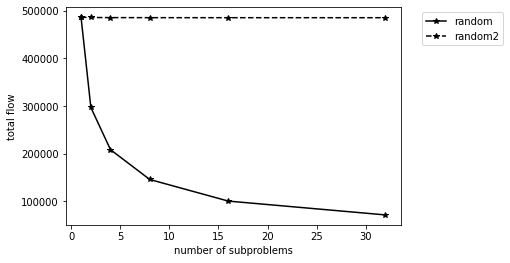

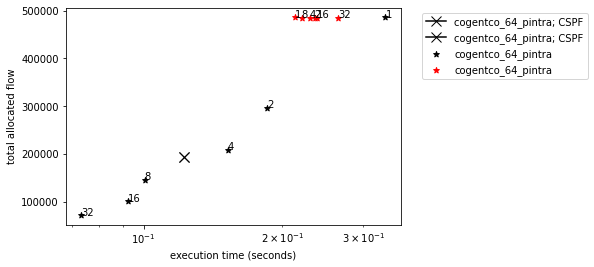

In [15]:
colors = ['k', 'r', 'b', 'g', 'm']
linestyles = ['-', '--', ':']
#print(results_ncflow)
#results_ncflow = results_ncflow[1::2]
#print(runtimes_ncflow)
def compute_obj_val(obj, problem, obj_vals, sol_dicts):
    if obj == 'max_flow':
        return sum(obj_vals)
    elif obj == 'min_max_link_util':
        link_utils_dict = defaultdict(int)
        for sol_dict in sol_dicts:
            for flow_list in sol_dict.values():
                for ((u, v), flow_val) in flow_list: # TODO: is this right? Or is it ((u, v), flow_val)?
                    link_utils_dict[(u, v)] += flow_val
        
        # TODO: is this right? Or is it ((u, v), c_e)?
        link_utils = {(u,v): link_utils_dict[(u, v)]/c_e for (u,v,c_e) in problem.G.edges.data('capacity')}
        return max(link_utils.values())
    
# run the benchmarks, plot results
def plot_split_results(problems, obj_type, results_all, 
                       runtimes_all, sol_dicts_all, 
                       results_cspf=None, runtimes_cspf=None,
                       results_ncflow=None, runtimes_ncflow=None):
    fig_results, ax_results = plt.subplots()
    plt.xlabel('number of subproblems')
    plt.ylabel('total flow')
    
    fig_rr, ax_rr = plt.subplots()
    
    plt.xlabel('execution time (seconds)')
    plt.ylabel('total allocated flow')
    #ymin, ymax = plt.ylim()
    #plt.ylim([0,ymax*1.1])
    
    for m_i, method in enumerate(split_methods):
        
        results = results_all[method]
        runtimes = runtimes_all[method]
        sol_dicts = sol_dicts_all[method]
      
        
        for p_i, p in enumerate(problems):
            total_obj_values = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
        #         sum_val = sum(results[p][n_i])
                total_obj_values.append(total_obj_val)
            ax_results.plot(num_subproblems, total_obj_values, marker='*', c=colors[p_i%len(colors)], 
                            linestyle=linestyles[m_i%len(linestyles)], label=method)
            if obj_type == 'max_flow' and results_ncflow is not None:
                ax_results.plot([1], [results_ncflow[p_i]])
        # plot performance vs runtime.
        for p_i, p in enumerate(problems):
            total_obj_values = []
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
                total_obj_values.append(total_obj_val)

                sum_val = sum(runtimes[p][n_i])
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            print(max_runtime)
            print(total_obj_values)
            ax_rr.scatter(max_runtime, total_obj_values, marker='*', c=colors[m_i%len(colors)], label=p[0])
            for n_i, n in enumerate(num_subproblems):
                ax_rr.annotate(n, (max_runtime[n_i], total_obj_values[n_i]))
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
            #    ax.plot(runtimes_ncflow[p_i], results_ncflow[p_i], marker='P', 
            #            markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
                ax_rr.plot(runtimes_cspf[p_i], results_cspf[p_i], marker='x', 
                    markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; CSPF")
    ax_results.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_rr.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_rr.set_xscale('log')    

    
plot_split_results(problems, 'max_flow', results_all_mf, runtimes_all_mf, 
               sol_dicts_all_mf,
               results_cspf, runtimes_cspf)
#plot_split_results(problems, 'min_max_link_util', results_all_mmlu, runtimes_all_mmlu, 
#               sol_dicts_all_mmlu,
#               results_cspf, runtimes_cspf)

## Firas's Work

In [ ]:
problem_name, topo_fname, tm_fname = p8
prob = Problem.from_file(topo_fname, tm_fname)
NUM_PATHS = 4
NUM_SUBPROBLEMS = 8

In [ ]:
def solve_subproblems(problem_list):
    sol_dicts, runtimes, obj_vals = [], [], []
    for sub_problem in problem_list:
        pf = PathFormulation.get_pf_for_obj(Objective.MAX_FLOW, NUM_PATHS)
        pf.solve(sub_problem)
        sol_dicts.append(pf.extract_sol_as_dict())
        runtimes.append(pf.runtime)
        obj_vals.append(pf.obj_val)
    #check
    return sol_dicts, runtimes, obj_vals

def solve_and_check_feasiblity(problem, num_subproblems, num_paths):    
    paths_dict = PathFormulation.new_max_flow(num_paths).get_paths(problem)
    problem_list = split_problem_smartpath(prob, num_subproblems, paths_dict)
    sol_dicts, runtimes, obj_vals = solve_subproblems(problem_list)
    check_feasibility(problem, sol_dicts)

In [ ]:
solve_and_check_feasiblity(prob, NUM_SUBPROBLEMS, NUM_PATHS)

# End Firas's Work

In [ ]:
def validate_solution(sol_dicts_all, num_subproblems):
    for obj_type in obj_types:
        sol_dicts = sol_dicts_all[obj_type]
        for p_spec in problems:
            problem = Problem.from_file(p_spec[1], p_spec[2a])
            com_list = problem.commodity_list
            
            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]
                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        assert_flow_conservation(flow_list, commod_key)
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow
            
                frac_demands_satisfied = {commod_key:
                                      merged_sol_dict[(commod_key[-1][0],
                                                       commod_key[-1][1])] / commod_key[-1][-1]
                                      for commod_key in com_list}
                for commod_key, frac in frac_demands_satisfied.items():
                    if frac > 1:
                        print("assertion error, demand oversatisfied "+ str(commod_key) + " " + str(frac))
                        break
                    

In [ ]:
results_all_obj = {}
runtimes_all_obj = {}
sol_dicts_all_obj = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=False)
    results_all_obj[obj_type] = results
    runtimes_all_obj[obj_type] = runtimes
    sol_dicts_all_obj[obj_type] = sol_dicts

In [ ]:
results_all_obj_smart = {}
runtimes_all_obj_smart = {}
sol_dicts_all_obj_smart = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=True, generic=False)
    results_all_obj_smart[obj_type] = results
    runtimes_all_obj_smart[obj_type] = runtimes
    sol_dicts_all_obj_smart[obj_type] = sol_dicts

In [ ]:
results_all_obj_smart_gen = {}
runtimes_all_obj_smart_gen = {}
sol_dicts_all_obj_smart_gen = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=True, generic=True)
    results_all_obj_smart_gen[obj_type] = results
    runtimes_all_obj_smart_gen[obj_type] = runtimes
    sol_dicts_all_obj_smart_gen[obj_type] = sol_dicts

In [ ]:
smart_results = [results_all_obj_smart, runtimes_all_obj_smart, sol_dicts_all_obj_smart]
pickle.dump(smart_results, open("results/smart_results.pkl", "wb"))

In [ ]:
[results_all_obj_smart, 
runtimes_all_obj_smart, 
sol_dicts_all_obj_smart] = pickle.load(open("results/smart_results.pkl", "rb"))

In [28]:
#run NCFlow on problem set
problems_ncflow = [(os.path.basename(p[1]), p[1], p[2]) for p in problems[8:]]
results_ncflow, runtimes_ncflow = ncflow.benchmark(problems_ncflow)

Kdl.graphml ../traffic-matrices/poisson-high-intra/Kdl.graphml_poisson_529831180_64.0_8000000000.0_0.35_4.3e-09_traffic-matrix.pkl
traffic seed: 529831180
traffic matrix model: poisson
traffic matrix scale factor: 64.0
total demand: 2831489.0

NCFlow, fm_partitioning partitioner, 81 partitions, 4 paths, edge disjoint True, dist metric inv-cap
cmd=[/lfs/1/fiodar/ncflow/ext/modularity/FastCommunity_w_GPL_v1.0.1/FastCommunity_wMH -f /lfs/1/fiodar/ncflow/ext/modularity/rundir/Kdl.graphml.wpairs -c 673]
Modularity: 0.814569
iteration 0

Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 4669 rows, 4385 columns and 23016 nonzeros


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4812078e+04   0.000000e+00   3.199984e+01      0s
       4    1.5082184e+04   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  1.508218439e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 154 rows, 132 columns and 520 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+03]
Presolve removed 142 rows and 90 columns
Presolve time: 0.00s
Presolved: 12 rows, 42 columns, 112 nonzeros

It


Solved in 18 iterations and 0.01 seconds
Optimal objective  1.662323125e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1184 rows, 1096 columns and 6210 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+03]
Presolve removed 814 rows and 622 columns
Presolve time: 0.01s
Presolved: 370 rows, 474 columns, 2000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1992814e+04   0.000000e+00   1.840000e+03      0s
     544    3.4787735e+04   0.000000e+00   0.000000e+00   

   Prev: gurobi.log  Default: 
Optimize a model with 234 rows, 208 columns and 880 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+03]
Presolve removed 220 rows and 152 columns
Presolve time: 0.01s
Presolved: 14 rows, 56 columns, 168 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5619920e+04   0.000000e+00   2.239981e+02      0s
      23    1.6164382e+04   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds
Optimal objective  1.616438175e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-24.txt


  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+03]
Presolve removed 1178 rows and 884 columns
Presolve time: 0.01s
Presolved: 514 rows, 714 columns, 3332 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5978510e+04   0.000000e+00   2.815997e+03      0s
     331    4.0099273e+04   0.000000e+00   0.000000e+00      0s

Solved in 331 iterations and 0.01 seconds
Optimal objective  4.009927325e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-32.txt
   Prev: gurobi.log  Default: 
Optimize a model with 72 rows, 60 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1510206e+04   0.000000e+00   5.183996e+03      0s
     470    5.6263894e+04   0.000000e+00   0.000000e+00      0s

Solved in 470 iterations and 0.02 seconds
Optimal objective  5.626389377e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 192 rows, 168 columns and 686 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+03]
Presolve removed 180 rows and 126 columns
Presolve time: 0.00s
Presolved: 12 rows, 42 columns, 112 nonzeros


Solved in 70 iterations and 0.01 seconds
Optimal objective  2.039378093e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-48.txt
   Prev: gurobi.log  Default: 
Optimize a model with 280 rows, 252 columns and 1104 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+03]
Presolve removed 264 rows and 180 columns
Presolve time: 0.00s
Presolved: 16 rows, 72 columns, 240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7197883e+04   0.000000e+00   2.959978e+02      0s
      30    1.8164298e+04   0.000000e+00   0.000000e+00      0s

   Prev: gurobi.log  Default: 
Optimize a model with 432 rows, 390 columns and 1838 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+03]
Presolve removed 320 rows and 222 columns
Presolve time: 0.01s
Presolved: 112 rows, 168 columns, 604 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1510591e+04   0.000000e+00   6.719988e+02      0s
     152    2.1934864e+04   0.000000e+00   0.000000e+00      0s

Solved in 152 iterations and 0.01 seconds
Optimal objective  2.193486415e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-57.

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+03]
Presolve removed 110 rows and 70 columns
Presolve time: 0.00s
Presolved: 10 rows, 30 columns, 70 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0608029e+04   0.000000e+00   4.799980e+01      0s
      11    1.1082127e+04   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds
Optimal objective  1.108212713e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-65.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1258 rows, 1168 columns and 6428 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]

       0    1.2608015e+04   0.000000e+00   4.799972e+01      0s
      12    1.3082129e+04   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds
Optimal objective  1.308212852e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-73.txt
   Prev: gurobi.log  Default: 
Optimize a model with 238 rows, 204 columns and 898 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 222 rows and 138 columns
Presolve time: 0.00s
Presolved: 16 rows, 66 columns, 172 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


Optimal objective  1.616443857e+04
edges in recon: {(18, 42): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-0-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk 


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 665, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(32, 27): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-2-64.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1227, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(62, 160): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-4-72.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.

  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1379, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(74, 269): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-6-29.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1692, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(98, 69): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-9-0.txt
   Prev: gurobi.log  Default: 
Optimize a mod

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 48, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(121, 237): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2152, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(385, 571): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2276, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(676, 680): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2580, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(182, 319): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2660, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(405, 409): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2779, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(213, 221): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 770, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(645, 635): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(118, 119): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metri

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1520, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(591, 592): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2553, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(680, 676): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 151, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(458, 545): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1184, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(360, 355): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 2995, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(42, 18): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2715, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(100, 103): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2196, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(432, 433): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 3651, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(549, 587): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-60-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 4137, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(47, 52): 0, (594, 35): 1}
Changed value of paramete

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-62-61.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 4236, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(285, 195

mk = 842, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(514, 199): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-65-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00

       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2246, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(530, 529): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-69-74.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Object

Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 3473, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(670, 561): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-71-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  1.000000000e+03
mk = 4031, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(697, 478): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-73-51.txt
   Prev: gurobi.log  Default: 
Optimize a

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1670, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(578, 707): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 2019, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(23, 25): 0, (171, 25): 1}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 231, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(512, 511): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

Optimal objective  7.705690308e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 97 rows, 78 columns and 234 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 97 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057642e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705764160e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 209 rows, 182 columns and 546 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705543213e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 129 rows, 100 columns and 300 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+03]
Presolve removed 129 rows and 100 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055609e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705560913e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 207 rows, 175 columns and 525 nonzeros
Coefficient statistics:
  Matrix ra

   Prev: gurobi.log  Default: 
Optimize a model with 281 rows, 230 columns and 690 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+03]
Presolve removed 281 rows and 230 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055286e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705528564e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 704 rows, 644 columns and 1932 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
S

   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7059711e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705971069e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All r

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057104e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705710449e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+03]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057013e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705701294e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 233 rows, 200 columns and 600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 233 rows and 200 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055603e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705560303e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7053857e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705385742e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 91 rows, 66 columns and 198 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 91 rows and 66 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7058307e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705830688e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055609e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705560913e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 75 columns and 225 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 95 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057806e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705780640e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+03]
Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7056647e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705664673e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+03]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055743e+02   0.000000e+00   0.000000e+00     

Presolve removed 77 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7056866e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705686646e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 65 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 65 rows and 50 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057019e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705701904e+02
Changed value of param

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7053741e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705374146e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 84 columns and 252 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+03]
Presolve removed 103 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7057202e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705720215e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 



Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705535889e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+03]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055829e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705582886e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range    

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 159 rows, 135 columns and 405 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 159 rows and 135 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7058057e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705805664e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 99 rows, 81 columns and 243 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7056659e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705665894e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055042e+02 

  RHS range        [9e-04, 1e+03]
Presolve removed 335 rows and 287 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7058051e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705805054e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7056836e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.7

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055585e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705558472e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+03]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7055493e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705549316e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Ch

       0    7.7055457e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705545654e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7056525e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.705652466e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 319 rows, 273

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7054333e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.705433350e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

   7   2.86573300e+04  2.90990414e+04  1.22e+00 8.77e-03  1.59e-01     0s
   8   2.85977158e+04  2.87607331e+04  2.91e-01 2.36e-03  4.34e-02     0s
   9   2.85918444e+04  2.86335889e+04  6.61e-02 4.15e-04  1.01e-02     0s
  10   2.85942876e+04  2.85991297e+04  6.01e-03 2.36e-05  9.86e-04     0s
  11   2.85951596e+04  2.85963877e+04  8.51e-04 4.60e-06  1.96e-04     0s
  12   2.85954262e+04  2.85956111e+04  7.44e-05 5.36e-07  2.52e-05     0s
  13   2.85954742e+04  2.85954828e+04  1.29e-07 1.76e-08  9.73e-07     0s
  14   2.85954762e+04  2.85954767e+04  4.61e-09 8.05e-10  4.97e-08     0s
  15   2.85954763e+04  2.85954764e+04  3.70e-09 8.45e-11  4.66e-09     0s

Barrier solved model in 15 iterations and 0.08 seconds
Optimal objective 2.85954763e+04

Crossover log...

      25 DPushes remaining with DInf 0.0000000e+00                 0s
       0 DPushes remaining with DInf 1.9984014e-15                 0s

     293 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushe

   Prev: gurobi.log  Default: 
Optimize a model with 221 rows, 179 columns and 837 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 2e+03]
Presolve removed 221 rows and 179 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9347366e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.934736609e+01
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 180 rows, 128 column

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-16.txt
   Prev: gurobi.log  Default: 
Optimize a model with 308 rows, 222 columns and 962 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-06, 3e+03]
Presolve removed 308 rows and 222 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5820597e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.582059709e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Def

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5233441e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.523344087e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-25.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9425 rows, 8715 columns and 68545 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 3e+03]
Presolve removed 9425 rows and 8715 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 3e+03]
Presolve removed 178 rows and 111 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2948700e+02   0.000000e+00   3.199990e+01      0s
       2    4.1260138e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.126013766e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3805 rows, 3582 columns and 26481 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 1e+00]


   Prev: gurobi.log  Default: 
Optimize a model with 1301 rows, 942 columns and 5889 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 4e+03]
Presolve removed 1301 rows and 942 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1738447e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.173844708e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-43.txt
   Prev: gurobi.log  Default: 
Optimize a model with 951 rows, 751 co

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-51.txt
   Prev: gurobi.log  Default: 
Optimize a model with 587 rows, 386 columns and 1820 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-06, 3e+03]
Presolve removed 587 rows and 386 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3288852e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.328885229e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  De

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2763484e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.276348401e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-60.txt
   Prev: gurobi.log  Default: 
Optimize a model with 607 rows, 309 columns and 1357 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e+03]
Presolve removed 607 rows and 309 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-05, 2e+03]
Presolve removed 749 rows and 659 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1069176e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.106917565e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-69.txt
   Prev: gurobi.log  Default: 
Optimize a model with 295 rows, 186 columns and 853 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-05, 2e+03]
Pres

   Prev: gurobi.log  Default: 
Optimize a model with 292 rows, 240 columns and 1081 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-05, 1e+03]
Presolve removed 292 rows and 240 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5558826e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.555882629e+01
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17947 rows, 16531 


Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(25, 23): 0, (25, 171): 1}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-1-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+03]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-3-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6332661e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.633266068e+01
mk = 311, before_recon (u_out= 46.333, v_in= 46.333) after_recon= 46.333
edges in recon: {(272, 534): 0}
Ch

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(589, 588): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-60.txt
   Prev: gurobi.log  Default: 
Optim

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(84, 25): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-8-1.txt
   Prev: gurobi.log  Default: 
Optimize

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(619, 620): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-10-80.txt
   Prev: gurobi.log  Default: 
Opti

Optimal objective -0.000000000e+00
edges in recon: {(561, 670): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-12-71.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0462796e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.046279602e+02


   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(358, 357): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-15-36.txt
   Prev: gurobi.log  Default: 
Opti

Optimal objective -0.000000000e+00
edges in recon: {(182, 318): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-18-76.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00


   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(405, 409): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-20-38.txt
   Prev: gurobi.log  Default: 
Opti

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1358002e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.135800189e+00
mk = 2986, before_recon (u_out= 1.280, v_in= 0.004) after_recon= 0.004
mk = 3093, before_recon (u_out= 5.634, v_in= 3.132) after_recon= 3.132
edges in recon: {(213, 221): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-23-55.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-25-67.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8747559e-02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.874755859e-02
mk = 732, before_recon (u_out= 53.895, v_in= 0.029) after_recon= 0.029
edges in recon: {(687, 703): 0}
Cha

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(441, 442): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-27-44.txt
   Prev: gurobi.log  Default: 
Opti

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4038086e-03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.403808594e-03
mk = 1499, before_recon (u_out= 216.624, v_in= 0.001) after_recon= 0.001
edges in recon: {(79, 74): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-30-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(294, 674): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-32-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2943665e+02   0.00000


Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(719, 6): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-34-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seco

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(482, 465): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-37-51.txt
   Prev: gurobi.log  Default: 
Opti

Optimal objective -0.000000000e+00
edges in recon: {(201, 206): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-39-22.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00


   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(545, 458): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-41-34.txt
   Prev: gurobi.log  Default: 
Opti

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4186560e-03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.418655959e-03
mk = 3760, before_recon (u_out= 0.001, v_in= 0.027) after_recon= 0.001
edges in recon: {(434, 400): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-43-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Pres

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Solved in 0 iterations and 0.01 seconds
Optimal objective  1.350230789e+02
mk = 976, before_recon (u_out= 156.512, v_in= 135.023) after_recon= 135.023
edges in recon: {(594, 595): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-61-62.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+0

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(211, 32): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-65-2.txt
   Prev: gurobi.log  Default: 
Optimi

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8643773e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.864377342e+01
mk = 4215, before_recon (u_out= 0.000, v_in= 0.000) after_recon= 0.000
mk = 4222, before_recon (u_out= 0.000, v_in= 0.000) after_recon= 0.000
mk = 4218, before_recon (u_out= 0.304, v_in= 0.469) after_recon= 0.304
mk = 4198, before_recon (u_out= 0.327, v_in= 0.566) after_recon= 0.327
mk = 732, before_recon (u_out= 0.029, v_in= 183.768) after_recon= 0.029
mk = 4219, before_recon (u_out= 17.930, v_in= 24.790) after_recon= 17.930
mk = 4197, before_recon (u_out= 0.054, v_in= 0.292) after_recon= 0.054
edges in recon: {(635, 645): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(666, 196): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-70-78.txt
   Prev: gurobi.log  Default: 
Opti

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(671, 153): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-72-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-74-2.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(83, 600): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8253754e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.825375366e+01
mk = 1068, before_recon (u_out= 48.254, v_in= 48.254) after_recon= 48.254
edges in recon: {(367, 197): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_i

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(512, 239): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/529831180-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-78-79.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.00000

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 3e+02]
Presolve removed 110 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0555997e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.055599689e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 138 rows, 116 columns and 348 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 3e+02]
Presolve removed 138 rows and 116 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

   Prev: gurobi.log  Default: 
Optimize a model with 155 rows, 125 columns and 375 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 3e+01]
Presolve removed 155 rows and 125 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7354277e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.735427678e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 233 rows, 200 columns and 600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 9e+00]
Presolve removed 233 rows and 200 columns
Presolve time: 0.00s
Presolv

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 3e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  2.178024597e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 469 rows, 414 columns and 1242 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 3e+02]
Presolve removed 469 rows and 414 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1563308e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 itera

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 2e-01]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8585024e-02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.858502418e-02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-06, 2e-02]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0045625e-02   0.000000e+00   0.000000e+00     

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2411980e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.241197968e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 58 rows, 44 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 58 rows and 44 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1566602e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.156660175e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+02]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3034443e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.303444290e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  6.073636189e-02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 155 rows, 125 columns and 375 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 3e+01]
Presolve removed 155 rows and 125 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7399465e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.739946455e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 281 rows, 230 columns and 690 nonzeros
Coefficient statistics:
  Matrix r

Optimal objective  3.027199909e-06
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 153 rows, 110 columns and 330 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 3e-04]
Presolve removed 153 rows and 110 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2559998e-07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.255999830e-07
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  

Optimize a model with 321 rows, 286 columns and 858 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 4e+00]
Presolve removed 321 rows and 286 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9591863e-01   0.000000e+00   0.000000e+00      0s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 2e-01]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0454401e-05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.045440073e-05
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e-01]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3416933e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4066689e-02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.406668920e-02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 65 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 5e-04]
Presolve removed 65 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1063040e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.106303971e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0    6.6759377e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.675937653e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 562 rows, 505 columns and 1515 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 3e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 562 rows and 505 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9521109e-01   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  4.952110946e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1

       0    3.0464638e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  3.046463826e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 1e+01]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4610513e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.461051345e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.106303971e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 135 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 6e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4162711e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.416271091e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix ra

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3043243e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.304324341e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 674 rows, 624 columns and 1872 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04,

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 9e-02]
Presolve removed 23 rows and 15 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1228797e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.122879710e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+01]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

   Prev: gurobi.log  Default: 
Optimize a model with 318 rows, 272 columns and 816 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 3e+02]
Presolve removed 318 rows and 272 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9565279e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.956527948e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 248 rows, 200 columns and 600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 4e-04]
Presolve removed 242 rows and 189 columns
Presolve time: 0.00s
Presolv

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 3e+02]
Presolve removed 64 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1608665e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.160866451e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+0

   Prev: gurobi.log  Default: 
Optimize a model with 96 rows, 77 columns and 231 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+02]
Presolve removed 96 rows and 77 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3035843e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.303584290e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 209 rows, 182 columns and 546 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 3e+01]
Presolve removed 209 rows and 182 columns
Presolve time: 0.00s
Presolve: A

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 90 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 3e-03]
Presolve removed 90 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7062400e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.706239964e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+01]
Presolve removed 29 rows and 20 column

Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-07, 1e-04]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5776000e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.577599955e-06
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 76 rows, 59 columns and 177 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 76 rows and 59 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteratio

   Prev: gurobi.log  Default: 
Optimize a model with 219 rows, 191 columns and 573 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+02]
Presolve removed 219 rows and 191 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2320969e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.232096863e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 134 rows, 111 columns and 333 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 3e+02]
Presolve removed 134 rows and 111 columns
Presolve time: 0.00s
Presolv

   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 3e+02]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9560905e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.956090450e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 77 columns and 231 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 9e+01]
Presolve removed 95 rows and 77 columns
Presolve time: 0.00s
Presolve: All r

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 2e+01]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1562958e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.156295776e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 38 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+02]
Presolve removed 38 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0105668e+01   0.000000e+00   0.000000e+00      

Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1563789e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.156378937e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e-02]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5365950e-03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.536595032e-03
Changed value of parame

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9574691e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.957469106e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 3e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9597645e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.959764481e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7337875e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.733787507e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 5e+01]
Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4602082e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.460208225e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.155939198e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 1e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9577993e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.957799315e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range   

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 2e-01]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1063679e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.106367943e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 318 rows, 272 columns and 816 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 60 rows, 44 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 3e-04]
Presolve removed 60 rows and 44 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7792001e-06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.779200080e-06
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 39 rows and 28 column

   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 5e-03]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3106559e-04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.310655884e-04
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e-03]
Presolve removed 23 rows and 15 columns
Presolve time: 0.01s
Presolve: All row

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-07, 4e-05]
Presolve removed 33 rows and 7 columns
Presolve time: 0.00s
Presolved: 9 rows, 21 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.849344e-04   0.000000e+00      0s
      11   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-05, 3e-01]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objectiv

   Prev: gurobi.log  Default: 
Optimize a model with 408 rows, 340 columns and 1716 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 4e+03]
Presolve removed 408 rows and 340 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7999953e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.799995334e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 320 rows, 282 colum

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-9.txt
   Prev: gurobi.log  Default: 
Optimize a model with 774 rows, 696 columns and 3682 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+03]
Presolve removed 720 rows and 620 columns
Presolve time: 0.01s
Presolved: 54 rows, 76 columns, 200 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9999933e+04   0.000000e+00   1.920000e+02      0s
      46    2.7999907e+04   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds
Optimal objective  2.799990686e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1


Presolve removed 288 rows and 234 columns
Presolve time: 0.00s
Presolved: 76 rows, 90 columns, 286 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1999967e+04   0.000000e+00   3.200000e+02      0s
      64    2.1999940e+04   0.000000e+00   0.000000e+00      0s

Solved in 64 iterations and 0.01 seconds
Optimal objective  2.199994001e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 576 rows, 504 columns and 2798 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 4e+03]

   Prev: gurobi.log  Default: 
Optimize a model with 1210 rows, 1122 columns and 6372 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+03]
Presolve removed 1098 rows and 984 columns
Presolve time: 0.01s
Presolved: 112 rows, 138 columns, 452 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3999920e+04   0.000000e+00   4.800000e+02      0s
     134    3.7999874e+04   0.000000e+00   0.000000e+00      0s

Solved in 134 iterations and 0.01 seconds
Optimal objective  3.799987383e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 416 rows, 364 columns and 1926 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+03]
Presolve removed 416 rows and 364 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9999940e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.999993973e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  De

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 6e+03]
Presolve removed 416 rows and 364 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9999966e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.999996615e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-44.txt
   Prev: gurobi.log  Default: 
Optimize a model with 560 rows, 504 columns and 2840 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+03]
Pre

   Prev: gurobi.log  Default: 
Optimize a model with 296 rows, 246 columns and 1140 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 4e+03]
Presolve removed 266 rows and 210 columns
Presolve time: 0.00s
Presolved: 30 rows, 36 columns, 84 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1999967e+04   0.000000e+00   9.600000e+01      0s
      26    1.7999951e+04   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds
Optimal objective  1.799995092e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-53.txt



Solved in 24 iterations and 0.01 seconds
Optimal objective  1.399994252e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-61.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1410 rows, 1318 columns and 8196 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+03]
Presolve removed 1045 rows and 929 columns
Presolve time: 0.01s
Presolved: 365 rows, 389 columns, 1845 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5999971e+04   0.000000e+00   1.792000e+03      0s
     323    4.1999925e+04   0.000000e+00   0.000000e+00  

   Prev: gurobi.log  Default: 
Optimize a model with 238 rows, 204 columns and 910 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 4e+03]
Presolve removed 238 rows and 204 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5999962e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.599996192e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-70.txt
   Prev: gurobi.log  Default: 
Optimize a model with 238 rows, 204 colum


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.199997285e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15532 rows, 15206 columns and 121617 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+03]
Presolve removed 12748 rows and 11800 columns
Presolve time: 0.03s
Presolved: 2784 rows, 3406 columns, 19637 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1999893e+04   0.000000e+00   1.264000e+04      0s
     265    1.2599974e+05   0.000000e+00   0.000

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-1-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 627, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(25, 84): 0

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-3-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 297, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(272, 534):

mk = 1354, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(400, 434): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-5-43.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00

       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1561, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(556, 553): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-7-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objecti

Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds
Optimal objective  1.000000000e+03
mk = 1865, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(105, 106): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-10-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 2091, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(553, 556): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-12-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient st

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2285, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(153, 671): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 429, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(167, 503): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2126, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(388, 139): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 182, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(206, 201): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 6 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 6 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 731, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(49, 490): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 0, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(654, 523): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metri

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2934, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(268, 266): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 2529, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(293, 290): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 3347, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(16, 15): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 3413, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(665, 71): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 2966, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(403, 378): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 934, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(503, 167): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1942, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(142, 141): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 3780, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(640, 233): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 850, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(370, 369): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-66-68.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 2435, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(652, 651): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-69-68.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient s

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 3442, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(703, 702): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 3102, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(523, 654): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1659, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(715, 714): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_me

   Prev: gurobi.log  Default: 
Optimize a model with 6 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 6 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 263, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(195, 285): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 239, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(239, 512): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_met

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+03]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 375 rows, 322 columns and 966 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 375 rows and 322 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 207 rows, 175 columns and 525 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 207 rows and 175 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 

Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 328 rows, 276 columns and 828 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 2e+03]
Presolve removed 328 rows and 276 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 377 rows, 328 columns and 984 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 377 rows and 328 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 251 rows, 205 columns and 615 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 251 rows and 2

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+03]
Presolve removed 363 rows and 325 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 2e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 74 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 74 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Chang

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 209 rows, 164 columns and 492 nonzeros
Coefficient statistics:
  Matrix range 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+03]
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 60 columns and 180 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 77 rows and 60 columns
Presolve time: 0.00s
Presolve: All r

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 220 rows, 192 columns and 576 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 220 rows and 192 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.000000

  RHS range        [3e-01, 2e+03]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+03]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.00

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 114 rows, 88 columns and 264 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+03]
Presolve removed 114 rows and 88 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 


Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 104 rows, 84 columns and 252 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 2e+03]
Presolve removed 104 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 74 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 129 rows, 100 columns and 300 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+03]
Presolve removed 129 rows and 100 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00,

Optimize a model with 55 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 55 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 55 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+03]
Presolve removed 39 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+03]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All ro

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+03]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03 

Presolve removed 31 rows and 21 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 74 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+03]
Presolve removed 74 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of param

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-3.txt
   Prev: gurobi.log  Default: 
Optimize a model with 96 rows, 84 columns and 238 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 96 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0

Presolve removed 96 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 4118 rows, 4028 columns and 24458 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 5e+02]
Presolve removed 4118 rows and 4028 columns
Presolve time: 0.01s
Preso

  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 126 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 96 rows, 84 columns and 238 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Boun

   Prev: gurobi.log  Default: 
Optimize a model with 96 rows, 84 columns and 230 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 96 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 126 rows, 112 columns a

   Prev: gurobi.log  Default: 
Optimize a model with 126 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 126 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1254 rows, 1204 col

   Prev: gurobi.log  Default: 
Optimize a model with 110 rows, 96 columns and 282 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 5e+02]
Presolve removed 110 rows and 96 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-48.txt
   Prev: gurobi.log  Default: 
Optimize a model with 160 rows, 144 columns

   Prev: gurobi.log  Default: 
Optimize a model with 192 rows, 174 columns and 608 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 192 rows and 174 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-57.txt
   Prev: gurobi.log  Default: 
Optimize a model with 272 rows, 252 colum

   Prev: gurobi.log  Default: 
Optimize a model with 418 rows, 388 columns and 1398 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 418 rows and 388 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-66.txt
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 18 column

   Prev: gurobi.log  Default: 
Optimize a model with 486 rows, 456 columns and 1836 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 486 rows and 456 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-75.txt
   Prev: gurobi.log  Default: 
Optimize a model with 286 rows, 262 colu

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(69, 98): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-0-9.txt
   Prev: gurobi.log  Default: 
Optimize

Optimal objective -0.000000000e+00
edges in recon: {(103, 100): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-2-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
e

Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(72, 432): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-42.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix rang

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-7-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(556, 553): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Defaul

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(105, 106): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-10-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-12-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(561, 670): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile t

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(319, 182): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-15-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-18-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(182, 318): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(197, 367): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-20-77.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-22-9.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(213, 221): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile t

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(645, 635): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-25-67.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-27-11.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(441, 442): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(79, 74): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-30-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RH

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-32-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(311, 16): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile t

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(327, 326): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-35-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-37-51.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(681, 684): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(408, 204): 0, (408, 411): 1}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-39-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-41-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(737, 750): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(438, 670): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-43-71.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(285, 195): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-63-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-65-64.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(370, 369): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(652, 651): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-69-68.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-71-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(160, 62): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to

  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(529, 530): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-74-69.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
 

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-75-76.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(318, 182): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile 

  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(204, 408): 0, (411, 408): 1}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-78-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/632211587-poisson/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-80-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(750, 737): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Defau

   Prev: gurobi.log  Default: 
Optimize a model with 112 rows, 84 columns and 344 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 4e+03]
Presolve removed 112 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999722e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999972159e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 134 rows, 1

   Prev: gurobi.log  Default: 
Optimize a model with 150 rows, 120 columns and 512 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 4e+03]
Presolve removed 150 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1999967e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.199996724e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-13.txt
   Prev: gurobi.log  Default: 
Optimize a model with 112 rows

   Prev: gurobi.log  Default: 
Optimize a model with 230 rows, 184 columns and 872 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+03]
Presolve removed 230 rows and 184 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3999961e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.399996070e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-22.txt
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows,

   Prev: gurobi.log  Default: 
Optimize a model with 112 rows, 84 columns and 350 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+03]
Presolve removed 112 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999719e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999971929e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 78 rows, 5

   Prev: gurobi.log  Default: 
Optimize a model with 90 rows, 72 columns and 264 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+03]
Presolve removed 90 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999691e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999969121e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 176 rows, 13

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 115, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(174, 138): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-1-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 r

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 152, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(14, 64): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 309, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(26, 29): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 241, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(37, 32): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 516, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(51, 28): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 607, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(19, 18): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 21, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(77, 152): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 782, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(92, 183): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tru

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 745, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(132, 135): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 864, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(128, 127): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 891, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(137, 172): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 663, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(148, 154): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1061, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(46, 47): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tru

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 442, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(48, 45): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1203, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(183, 158): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_T

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 1084, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(186, 165): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_T

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+03]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+03]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+03]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All row

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 3e+03]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parame

       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+03]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+03]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e

Optimize a model with 23 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+03]
Presolve removed 23 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+03]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration  

   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 columns and 26 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 2e+03]
Presolve removed 16 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 52 co

   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 columns and 56 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+03]
Presolve removed 30 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-13.txt
   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 c

   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 columns and 56 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+03]
Presolve removed 30 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-22.txt
   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 c

   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 columns and 26 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 2e+03]
Presolve removed 16 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 6 rows, 4 col

   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 columns and 56 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 2e+03]
Presolve removed 30 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 c

Optimal objective -0.000000000e+00
edges in recon: {(174, 138): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-1-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.0000

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(15, 13): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-4.txt
   Prev: gurobi.log  Default

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(25, 171): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-8-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(37, 160): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-10-33.txt
   Prev: gurobi.log  Defa

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(57, 56): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-13-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(82, 83): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-16-32.txt
   Prev: gurobi.log  Defau

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(70, 183): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-19-38.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(171, 25): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-21-8.txt
   Prev: gurobi.log  Defau

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(107, 129): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-25-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-38-33.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(183, 158): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of paramet

Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(186, 165): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/2075712807-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-40-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:


  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 7e+03]
Presolve removed 176 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1999983e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.199998316e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 150 rows, 120 columns and 512 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0

   Prev: gurobi.log  Default: 
Optimize a model with 112 rows, 84 columns and 344 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 8e+03]
Presolve removed 112 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999874e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999987378e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 176 rows, 

   Prev: gurobi.log  Default: 
Optimize a model with 372 rows, 320 columns and 1536 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 8e+03]
Presolve removed 372 rows and 320 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9999974e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.999997429e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 230 row

   Prev: gurobi.log  Default: 
Optimize a model with 150 rows, 120 columns and 524 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 7e+03]
Presolve removed 150 rows and 120 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1999983e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.199998317e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-28.txt
   Prev: gurobi.log  Default: 
Optimize a model with 330 rows

   Prev: gurobi.log  Default: 
Optimize a model with 42 rows, 28 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+02, 7e+03]
Presolve removed 42 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9999916e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.999991647e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-37.txt
   Prev: gurobi.log  Default: 
Optimize a model with 928 rows, 860


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 109, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(131, 142): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-0-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 186, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(32, 37): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-3-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 296, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(188, 51): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-6-13.txt
   Prev: gurobi.log  Default: 
Op

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 346, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(18, 19): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 486, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(45, 48): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 585, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(60, 69): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 636, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(74, 183): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tru

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 387, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(79, 71): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 809, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(97, 96): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 884, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(123, 124): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 80, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(135, 132): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tru

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 973, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(143, 42): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tru

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1007, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(162, 77): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
mk = 552, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(166, 147): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1198, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(183, 75): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_Tr

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
mk = 1170, before_recon (u_out= 1000.000, v_in= 1000.000) after_recon= 1000.000
edges in recon: {(185, 143): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_T

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-04, 6e+03]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-03, 6e+03]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [6e-02, 6e+03]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 6e+03]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 6e+03]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 6e+03]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 6e+03]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.

Presolve removed 29 rows and 20 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 6e+03]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parame

       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 6e+03]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+03]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0

Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 6e+03]
Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+03
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r3.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5714 rows, 1218 columns and 9950 nonzeros
Coefficie

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 48 rows, 40 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 5e+03]
Presolve removed 48 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

S

  RHS range        [6e+02, 5e+03]
Presolve removed 16 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 48 rows, 40 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 5e+03]
Presolve removed 48 rows and 40

   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 columns and 26 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+02, 5e+03]
Presolve removed 16 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-23.txt
   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 c

   Prev: gurobi.log  Default: 
Optimize a model with 6 rows, 4 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 5e+03]
Presolve removed 6 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-32.txt
   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 column

   Prev: gurobi.log  Default: 
Optimize a model with 16 rows, 12 columns and 26 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+02, 5e+03]
Presolve removed 16 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 24 c


Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(8, 7): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(127, 128): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-27.txt
   Prev: gurobi.log  Defa

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(28, 26): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-8-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(37, 38): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-10-37.txt
   Prev: gurobi.log  Defau

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(52, 55): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-14-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00  

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(71, 79): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-17-19.txt
   Prev: gurobi.log  Defau

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(78, 94): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-19-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(97, 96): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-22-21.txt
   Prev: gurobi.log  Defau

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(167, 162): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1776689782-poisson/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-39-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations a

   Prev: gurobi.log  Default: 
Optimize a model with 7644 rows, 1218 columns and 13810 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1218 rows and 7644 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.03 seconds
Optimal objective -0.000000000e+00
Runtime breakdown: R1 0.03527212142944336 R2// 0.02411174774169922 Recon// 0.06444978713989258 R3 0.03476405143737793 Kirchoffs// 0.0 #threads 14
Runtime breakdown: R1 0.010804891586303711 R2// 0.01647806167602539 Recon// 0.057363033294677734 R3 0.020513057708740234 Kirchoffs// 0.05777883529663086 #threads 28
Run

In [ ]:
colors = ['k', 'r', 'b', 'g']
linestyles = ['-', '--', ':']
#print(results_ncflow)
#results_ncflow = results_ncflow[1::2]
#print(runtimes_ncflow)
def compute_obj_val(obj, problem, obj_vals, sol_dicts):
    if obj == 'max_flow':
        return sum(obj_vals)
    elif obj == 'min_max_link_util':
        link_utils_dict = defaultdict(int)
        for sol_dict in sol_dicts:
            for flow_list in sol_dict.values():
                for ((u, v), flow_val) in flow_list: # TODO: is this right? Or is it ((u, v), flow_val)?
                    link_utils_dict[(u, v)] += flow_val
        
        # TODO: is this right? Or is it ((u, v), c_e)?
        link_utils = {(u, v): link_utils_dict[(u, v)] / c_e for (u, v, c_e) in problem.G.edges.data('capacity')}
        return max(link_utils.values())
    
# run the benchmarks, plot results
def plot_benchmark(results_all, runtimes_all, sol_dicts_all, results_ncflow, runtimes_ncflow,
                  results_cspf, runtimes_cspf):
    for obj_type in obj_types:
        
        results = results_all[obj_type]
        runtimes = runtimes_all[obj_type]
        sol_dicts = sol_dicts_all[obj_type]
        
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
        #         sum_val = sum(results[p][n_i])
                total_obj_values.append(total_obj_val)
            ax.plot(num_subproblems, total_obj_values, marker='*', c=colors[p_i%len(colors)], linestyle=linestyles[p_i%len(linestyles)],
                    label=p[0])
            #if (obj_type == "max_flow"):
                #also plot flow achieved by ncflow
                #ax.plot(1, results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('total flow')
        #plt.ylim([0,None])
        #plt.savefig('./plots/flow_'+p[0]+'.png', bbox_inches='tight')

        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                sum_val = sum(runtimes[p][n_i])
                print(sum_val)
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            ax.plot(num_subproblems, total_runtime, marker='*', linestyle=linestyles[0], 
                    c=colors[p_i%len(colors)], label='sum ' + p[0])
            ax.plot(num_subproblems, max_runtime, marker='^', linestyle=linestyles[1], 
                    c=colors[p_i%len(colors)], label='max ' + p[0])
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(1, runtimes_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('execution time (seconds)')
        plt.ylim([0,None])
        #plt.savefig('./plots/runtime_'+p[0]+'.png', bbox_inches='tight')

        # plot performance vs runtime.
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
                total_obj_values.append(total_obj_val)

                sum_val = sum(runtimes[p][n_i])
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            print(max_runtime)
            print(total_obj_values)
            ax.scatter(max_runtime, total_obj_values, marker='*', c=colors[p_i%len(colors)], label=p[0])
            for n_i, n in enumerate(num_subproblems):
                ax.annotate(n, (max_runtime[n_i], total_obj_values[n_i]))
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(runtimes_ncflow[p_i], results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
                ax.plot(runtimes_cspf[p_i], results_cspf[p_i], marker='x', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; CSPF")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('execution time (seconds)')
        plt.ylabel('total allocated flow')
        ymin, ymax = plt.ylim()
        plt.ylim([0,ymax*1.1])
        ax.set_xscale('log')
        """
        for p_spec in probs:
            break
            problem = Problem.from_file(p_spec[1], p_spec[2])
            com_list = problem.commodity_list

            fig,ax = plt.subplots()

            # plot the demand distribution
            demands = [ com_list[i][1][2] for i in range(len(com_list)) ]
            num_bins = 100
            counts, bin_edges = np.histogram(demands, bins=num_bins)
            cdf = np.cumsum(counts)
            ax.plot(bin_edges[1:], cdf/cdf[-1], c='m', label="demands")

            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]


                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow

                    # get amount of flow assigned to each commodity (ASSUMING SINGLE PATH)
                    #flow_counts += [ sol_dict[sdf][0][1] for sdf in sol_dict if len(sol_dict[sdf]) > 0 ]

                frac_demands_satisfied = {commod_key:
                                          merged_sol_dict[(commod_key[-1][0],
                                                           commod_key[-1][1])] / commod_key[-1][-1]
                                          for commod_key in com_list}

                # take frac_demands_satisfied, extract list, plot cdf
                num_bins = 100
                #print("sol_dict: " + str(sum(flow_counts)) + ", actual obj: " + str(sum(results[p][n_i])))
                counts, bin_edges = np.histogram(flow_counts, bins=num_bins)
                cdf = np.cumsum(counts)
                ax.plot(bin_edges[1:], cdf/cdf[-1], c=colors[n_i], label=str(n)+" subproblems")

            plt.xlabel('per-commodity allocated flow')
            plt.ylabel('cumulative')
            plt.legend()
"""
    

In [24]:
#problems = [p6]
#plot_benchmark(results_all_obj, runtimes_all_obj, sol_dicts_all_obj, 
#               results_ncflow, runtimes_ncflow)
#results_ncflow = None
#runtimes_ncflow = None
plot_benchmark(results_all_obj_smart, runtimes_all_obj_smart, 
               sol_dicts_all_obj_smart, results_ncflow, runtimes_ncflow,
               results_cspf, runtimes_cspf)

plot_benchmark(results_all_obj_smart_gen, runtimes_all_obj_smart_gen, 
               sol_dicts_all_obj_smart_gen, results_ncflow, runtimes_ncflow,
               results_cspf, runtimes_cspf)


NameError: name 'plot_benchmark' is not defined

In [ ]:

#problem = Problem.from_file("../topologies/topology-zoo/GtsCe.graphml", 
#                            "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
#problem.G
#print(problem.G.edges.data())
#com_list = problem.commodity_list
#problem2 = problem.copy()
#print(dir(problem))

#pf = PathFormulation.new_max_flow(
#                    num_paths,
#                    edge_disjoint=edge_disjoint,
#                    dist_metric=dist_metric)
        
#paths_dict = pf.get_paths(problem)
#com0 = com_list[3]
#print(com0)
#print(paths_dict[(com0[1][0],com0[1][1])])

"""
problem2.traffic_matrix.tm
new_tm = problem2.traffic_matrix.tm[0:10,:]

num_rows = len(problem2.traffic_matrix.tm)

shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)

num_first_problem = math.floor(num_rows/2)

for i in shuffled_indices[1:num_first_problem]:
    problem2.traffic_matrix.tm[i,:] = 0

#print(problem2.traffic_matrix.tm[1:5,:])

for u,v in problem.G.edges:
    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2
    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2
"""

In [12]:
def CSPF(problems):
    
    results_all = []
    runtimes_all = []
    
    for problem_name, topo_fname, tm_fname in problems:
        problem = Problem.from_file(topo_fname, tm_fname)
        
        com_list = problem.commodity_list
        tm = problem.traffic_matrix.tm
        
        pf = PathFormulation.new_max_flow(
                    num_paths,
                    edge_disjoint=edge_disjoint,
                    dist_metric=dist_metric)
        
        paths_dict = pf.get_paths(problem)
        
        # initialize link capacity dict
        remaining_link_capacity_dict = {}
        for u,v in problem.G.edges:
            remaining_link_capacity_dict[(u,v)] = problem.G[u][v]['capacity']
            
        # sort paths in ascending order
        all_paths_list = []
        allocated_coms = {}
        for k, (source, target, demand) in com_list:
            paths_array = paths_dict[(source, target)]
            all_paths_list += paths_array
            allocated_coms[(source,target)] = False
        all_paths_list.sort(key=len)
        
        # iterate through sorted paths
        total_allocated_flow = 0
        startTime = datetime.now()
        for path in all_paths_list:
            source = path[0]
            target = path[-1]
            demand = tm[source,target]
            
            # skip if we have already allocated this commodity
            if allocated_coms[(source,target)]:
                continue
            
            # check that each edge in list has enough capacity
            edge_list = list(path_to_edge_list(path))
            room = True
            for u,v in edge_list:
                if remaining_link_capacity_dict[(u,v)] < demand:
                    room = False
                    break
            
            if not room:
                continue
            
            # allocate
            for u,v in edge_list:
                remaining_link_capacity_dict[(u,v)] -= demand
            allocated_coms[(source, target)] = True
            total_allocated_flow += demand
        runtime = datetime.now() - startTime
        
        results_all.append(total_allocated_flow)
        runtimes_all.append(runtime.total_seconds())
        print("Runtime: " + str(runtime))
        print("Allocated Flow:" + str(total_allocated_flow))
    return results_all, runtimes_all

In [13]:
num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
results_cspf, runtimes_cspf = CSPF(problems)

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Cogentco.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 38612
Runtime: 0:00:00.122270
Allocated Flow:192832.47433094343


In [ ]:
print(results_ncflow)